In [1]:
MODEL_TYPE='protenix'
VALIDATION=True

In [2]:
!pip show biopython


Name: biopython
Version: 1.85
Summary: Freely available tools for computational molecular biology.
Home-page: https://biopython.org/
Author: The Biopython Contributors
Author-email: biopython@biopython.org
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy
Required-by: protenix


## Install requirements 

RNA 3D 예측 결과와 실제 구조를 비교하고, 이를 평가하는 파이프 라인.

In [3]:
if MODEL_TYPE=='protenix' and VALIDATION:
    !pip install --no-deps protenix
    !pip install biopython
    !pip install ml-collections
    !pip install biotite==1.0.1
    !pip install rdkit
!export PROTENIX_DATA_ROOT_DIR=/kaggle/input/protenix-checkpoints

In [4]:
! mkdir /af3-dev 
! ln -s /kaggle/input/protenix-checkpoints /af3-dev/release_data
! ls /af3-dev/release_data/

components.v20240608.cif		model_v0.2.0.pt
components.v20240608.cif.rdkit_mol.pkl


## Helper scripts

In [5]:
import Bio

from copy import deepcopy

import pandas as pd
from Bio.PDB import Atom, Model, Chain, Residue, Structure, PDBParser
from Bio import SeqIO
import os, sys
import re
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
time0=time.time()
from Bio import AlignIO
print('IMPORT OK !!!!')

IMPORT OK !!!!


In [6]:
PYTHON = sys.executable
print('PYTHON',PYTHON)

RHONET_DIR=\
'/kaggle/input/data-for-demo-for-rhofold-plus-with-kaggle-msa/RhoFold-main'
#'<your downloaded rhofold repo>/RhoFold-main'

USALIGN = \
'/kaggle/working//USalign'
#'<your us align path>/USalign'

os.system('cp /kaggle/input/usalign/USalign /kaggle/working/')
os.system('sudo chmod u+x /kaggle/working//USalign')
sys.path.append(RHONET_DIR)


DATA_KAGGLE_DIR = '/kaggle/input/stanford-rna-3d-folding'


# helper ----
# 딕셔너리 <-> 키 매핑
class dotdict(dict):
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

	def __getattr__(self, name):
		try:
			return self[name]
		except KeyError:
			raise AttributeError(name)

# visualisation helper ----
def set_aspect_equal(ax):
	x_limits = ax.get_xlim()
	y_limits = ax.get_ylim()
	z_limits = ax.get_zlim()

	# Compute the mean of each axis
	x_middle = np.mean(x_limits)
	y_middle = np.mean(y_limits)
	z_middle = np.mean(z_limits)

	# Compute the max range across all axes
	max_range = max(x_limits[1] - x_limits[0],
					y_limits[1] - y_limits[0],
					z_limits[1] - z_limits[0]) / 2.0

	# Set the new limits to ensure equal scaling
	ax.set_xlim(x_middle - max_range, x_middle + max_range)
	ax.set_ylim(y_middle - max_range, y_middle + max_range)
	ax.set_zlim(z_middle - max_range, z_middle + max_range)




# xyz df helper --------------------
def get_truth_df(target_id):
    truth_df = LABEL_DF[LABEL_DF['target_id'] == target_id]
    truth_df = truth_df.reset_index(drop=True)
    return truth_df

def parse_output_to_df(output, seq, target_id):
    df = []
    chain_data = []
    for i, res in enumerate(seq):
        d=dict(ID = target_id,
                    resname=res,
                    resid=i+1)
        for n in range(len(output)):
            d={**d, f'x_{n+1}': round(output[n,i,0].item(),3),
                     f'y_{n+1}': round(output[n,i,1].item(),3),
                     f'z_{n+1}': round(output[n,i,2].item(),3)}
        chain_data.append(d)

    if len(chain_data)!=0:
        chain_df = pd.DataFrame(chain_data)
        df.append(chain_df)
        ##print(chain_df)
    return df

def parse_pdb_to_df(pdb_file, target_id):
    parser = PDBParser()
    structure = parser.get_structure('', pdb_file)

    df = []
    for model in structure:
        for chain in model:
            print(chain)
            chain_data = []
            for residue in chain:
                # print(residue)
                if residue.get_resname() in ['A', 'U', 'G', 'C']:
                    # Check if the residue has a C1' atom
                    if 'C1\'' in residue:
                        atom = residue['C1\'']
                        xyz = atom.get_coord()
                        resname = residue.get_resname()
                        resid = residue.get_id()[1]

                        #todo detect discontinous: resid = prev_resid+1
                        #ID	resname	resid	x_1	y_1	z_1
                        chain_data.append(dict(
                            ID = target_id+'_'+str(resid),
                            resname=resname,
                            resid=resid,
                            x_1=xyz[0],
                            y_1=xyz[1],
                            z_1=xyz[2],
                        ))
                        ##print(f"Residue {resname} {resid}, Atom: {atom.get_name()}, xyz: {xyz}")

            if len(chain_data)!=0:
                chain_df = pd.DataFrame(chain_data)
                df.append(chain_df)
                ##print(chain_df)
    return df

# usalign helper --------------------
def write_target_line(
    atom_name, atom_serial, residue_name, chain_id, residue_num, x_coord, y_coord, z_coord, occupancy=1.0, b_factor=0.0, atom_type='P'
):
    """
    Writes a single line of PDB format based on provided atom information.

    Args:
        atom_name (str): Name of the atom (e.g., "N", "CA").
        atom_serial (int): Atom serial number.
        residue_name (str): Residue name (e.g., "ALA").
        chain_id (str): Chain identifier.
        residue_num (int): Residue number.
        x_coord (float): X coordinate.
        y_coord (float): Y coordinate.
        z_coord (float): Z coordinate.
        occupancy (float, optional): Occupancy value (default: 1.0).
        b_factor (float, optional): B-factor value (default: 0.0).

    Returns:
        str: A single line of PDB string.
    """
    return f'ATOM  {atom_serial:>5d}  {atom_name:<5s} {residue_name:<3s} {residue_num:>3d}    {x_coord:>8.3f}{y_coord:>8.3f}{z_coord:>8.3f}{occupancy:>6.2f}{b_factor:>6.2f}           {atom_type}\n'

def write_xyz_to_pdb(df, pdb_file, xyz_id = 1):
    resolved_cnt = 0
    with open(pdb_file, 'w') as target_file:
        for _, row in df.iterrows():
            x_coord = row[f'x_{xyz_id}']
            y_coord = row[f'y_{xyz_id}']
            z_coord = row[f'z_{xyz_id}']

            if x_coord > -1e17 and y_coord > -1e17 and z_coord > -1e17:
                resolved_cnt += 1
                target_line = write_target_line(
                    atom_name="C1'",
                    atom_serial=int(row['resid']),
                    residue_name=row['resname'],
                    chain_id='0',
                    residue_num=int(row['resid']),
                    x_coord=x_coord,
                    y_coord=y_coord,
                    z_coord=z_coord,
                    atom_type='C',
                )
                target_file.write(target_line)
    return resolved_cnt

def parse_usalign_for_tm_score(output):
    # Extract TM-score based on length of reference structure (second)
    tm_score_match = re.findall(r'TM-score=\s+([\d.]+)', output)[1]
    if not tm_score_match:
        raise ValueError('No TM score found')
    return float(tm_score_match)

def parse_usalign_for_transform(output):
    # Locate the rotation matrix section
    matrix_lines = []
    found_matrix = False

    for line in output.splitlines():
        if "The rotation matrix to rotate Structure_1 to Structure_2" in line:
            found_matrix = True
        elif found_matrix and re.match(r'^\d+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+\s+[-\d.]+$', line):
            matrix_lines.append(line)
        elif found_matrix and not line.strip():
            break  # Stop parsing if an empty line is encountered after the matrix

    # Parse the rotation matrix values
    rotation_matrix = []
    for line in matrix_lines:
        parts = line.split()
        row_values = list(map(float, parts[1:]))  # Skip the first column (index)
        rotation_matrix.append(row_values)

    return np.array(rotation_matrix)

def call_usalign(predict_df, truth_df, verbose=1):
    truth_pdb = '~truth.pdb'
    predict_pdb = '~predict.pdb'
    write_xyz_to_pdb(predict_df, predict_pdb, xyz_id=1)
    write_xyz_to_pdb(truth_df, truth_pdb, xyz_id=1)

    command = f'{USALIGN} {predict_pdb} {truth_pdb} -atom " C1\'" -m -'
    output = os.popen(command).read()
    if verbose==1:
        print(output)
    tm_score = parse_usalign_for_tm_score(output)
    transform = parse_usalign_for_transform(output)
    return tm_score, transform

print('HELPER OK!!!')

PYTHON /usr/bin/python3
HELPER OK!!!


In [7]:
if MODEL_TYPE=='protenix':
    
    
    from runner.batch_inference import get_default_runner
    from runner.inference import update_inference_configs, InferenceRunner

    from protenix.data.infer_data_pipeline import InferenceDataset

    np.random.seed(0)
    torch.random.manual_seed(0)
    torch.cuda.manual_seed_all(0)

class DictDataset(InferenceDataset):
    def __init__(
        self,
        seq_list: list,
        dump_dir: str,
        id_list: list = None,
        msa_root_1: str = "/kaggle/input/stanford-rna-3d-folding/MSA",
        msa_root_2: str = "/kaggle/input/stanford-rna-3d-folding/MSA_v2",
    ) -> None:
        self.dump_dir = dump_dir
        self.msa_roots = [msa_root_2, msa_root_1]  # 우선순위: v2 > v1

        if isinstance(id_list, type(None)):
            self.inputs = [{"sequences": [{"rnaSequence": {"sequence": seq, "count": 1}}], "name": "query"}
                           for seq in seq_list]
        else:
            self.inputs = [{"sequences": [{"rnaSequence": {"sequence": seq, "count": 1}}], "name": i}
                           for i, seq in zip(id_list, seq_list)]

    def __getitem__(self, index):
        data, atom_array, error_msg = super().__getitem__(index)
        target_id = self.inputs[index]["name"]

        # MSA 파일 탐색
        msa_tensor = None
        for root in self.msa_roots:
            msa_path = os.path.join(root, f"{target_id}.MSA.fasta")
            if os.path.exists(msa_path):
                try:
                    msa_tensor = self.load_msa_fasta(msa_path)
                    print(f"✅ Loaded MSA for {target_id} from {root} | shape={msa_tensor.shape}")
                    break
                except Exception as e:
                    print(f"⚠️ Error loading MSA for {target_id}: {e}")

        if msa_tensor is not None:
            if "input_feature_dict" not in data:
                data["input_feature_dict"] = {}  # ← 이 줄 추가!
            data["input_feature_dict"]["msa_feat"] = msa_tensor
            print(f"✅ Loaded MSA for {target_id} from {root} | shape={msa_tensor.shape}")

        else:
            print(f"❌ No MSA found for {target_id}")

        return data, atom_array, error_msg

    def load_msa_fasta(self, msa_path):
        alignment = AlignIO.read(msa_path, "fasta")
        alignment = alignment[:64]  # optional limit
        L = len(alignment[0])
        N = len(alignment)
        msa_tensor = torch.zeros((N, L), dtype=torch.long)

        for i, record in enumerate(alignment):
            msa_tensor[i] = torch.tensor([
                ord(residue) if residue != '-' else 0  # gap은 0으로 처리
                for residue in record.seq
            ])
        return msa_tensor

In [8]:
if MODEL_TYPE=='protenix':

    from configs.configs_base import configs as configs_base
    from configs.configs_data import data_configs
    from configs.configs_inference import inference_configs
    from protenix.config.config import parse_configs

    configs_base["use_deepspeed_evo_attention"] = (
    os.environ.get("USE_DEEPSPEED_EVO_ATTENTION", False) == "true")
    configs_base["model"]["N_cycle"] = 10 #10
    configs_base["sample_diffusion"]["N_sample"] = (1 if VALIDATION else 5)
    configs_base["sample_diffusion"]["N_step"] = 200
    inference_configs['load_checkpoint_path']='/kaggle/input/protenix-checkpoints/model_v0.2.0.pt'
    configs = {**configs_base, **{"data": data_configs}, **inference_configs}

    configs = parse_configs(
            configs=configs,
            fill_required_with_null=True,
        )
    
    runner=InferenceRunner(configs)
    print(type(runner.model))          # 클래스 이름
    print(runner.model)                # 전체 구조 요약

train scheduler 16.0
inference scheduler 16.0
Diffusion Module has 16.0


/usr/local/lib/python3.10/dist-packages/runner/inference.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, self.device)


<class 'protenix.model.protenix.Protenix'>
Protenix(
  (input_embedder): InputFeatureEmbedder(
    (atom_attention_encoder): AtomAttentionEncoder(
      (linear_no_bias_f): Linear(in_features=389, out_features=128, bias=False)
      (linear_no_bias_d): Linear(in_features=3, out_features=16, bias=False)
      (linear_no_bias_invd): Linear(in_features=1, out_features=16, bias=False)
      (linear_no_bias_v): Linear(in_features=1, out_features=16, bias=False)
      (linear_no_bias_cl): Linear(in_features=128, out_features=16, bias=False)
      (linear_no_bias_cm): Linear(in_features=128, out_features=16, bias=False)
      (small_mlp): Sequential(
        (0): ReLU()
        (1): Linear(in_features=16, out_features=16, bias=False)
        (2): ReLU()
        (3): Linear(in_features=16, out_features=16, bias=False)
        (4): ReLU()
        (5): Linear(in_features=16, out_features=16, bias=False)
      )
      (atom_transformer): AtomTransformer(
        (diffusion_transformer): Diffusion

In [9]:
if VALIDATION:
    LABEL_DF = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_labels.csv')
    LABEL_DF['target_id'] = LABEL_DF['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    train_df=pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_sequences.csv')


  0%|          | 2/844 [00:12<1:13:23,  5.23s/it]

✅ Loaded MSA for 1SCL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 1SCL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 1RNK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 34])
✅ Loaded MSA for 1RNK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 34])


  0%|          | 4/844 [00:12<25:09,  1.80s/it]

✅ Loaded MSA for 1RHT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 24])
✅ Loaded MSA for 1RHT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 24])
✅ Loaded MSA for 1HLX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 20])
✅ Loaded MSA for 1HLX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 20])


  1%|          | 7/844 [00:13<08:56,  1.56it/s]

✅ Loaded MSA for 1HMH_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1HMH_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1RNG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 1RNG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 1MME_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 25])
✅ Loaded MSA for 1MME_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 25])


  1%|          | 8/844 [00:13<07:05,  1.96it/s]

✅ Loaded MSA for 1KAJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 1KAJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 1SLO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 19])
✅ Loaded MSA for 1SLO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 19])


  1%|▏         | 11/844 [00:13<04:00,  3.46it/s]

✅ Loaded MSA for 1BIV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 28])
✅ Loaded MSA for 1BIV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 28])
✅ Loaded MSA for 1ANR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 1ANR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 1ZIG_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 12])
✅ Loaded MSA for 1ZIG_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 12])


  2%|▏         | 13/844 [00:13<02:46,  5.01it/s]

✅ Loaded MSA for 1ZIH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 1ZIH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 1ETF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([33, 34])
✅ Loaded MSA for 1ETF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([33, 34])


  2%|▏         | 16/844 [00:14<02:14,  6.13it/s]

✅ Loaded MSA for 1ZIF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 1ZIF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 1KPD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 32])
✅ Loaded MSA for 1KPD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 32])


  2%|▏         | 19/844 [00:14<01:42,  8.09it/s]

✅ Loaded MSA for 1IKD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([28, 22])
✅ Loaded MSA for 1IKD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([28, 22])
✅ Loaded MSA for 1ZDI_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])
✅ Loaded MSA for 1ZDI_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])
✅ Loaded MSA for 1AFX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 1AFX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])


  2%|▏         | 21/844 [00:14<01:45,  7.81it/s]

✅ Loaded MSA for 1EBQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([38, 29])
✅ Loaded MSA for 1EBQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([38, 29])
✅ Loaded MSA for 1EBR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 1EBR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])


  3%|▎         | 24/844 [00:15<01:31,  8.95it/s]

✅ Loaded MSA for 1ULL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 35])
✅ Loaded MSA for 1ULL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 35])
✅ Loaded MSA for 1KIS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 1KIS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 1KIS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 1KIS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


  3%|▎         | 26/844 [00:15<01:31,  8.97it/s]

✅ Loaded MSA for 1ATO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([55, 19])
✅ Loaded MSA for 1ATO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([55, 19])
✅ Loaded MSA for 1TLR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 23])
✅ Loaded MSA for 1TLR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 23])
✅ Loaded MSA for 1VOP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 13])
✅ Loaded MSA for 1VOP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 13])


  4%|▎         | 30/844 [00:15<01:20, 10.11it/s]

✅ Loaded MSA for 1AQO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([57, 29])
✅ Loaded MSA for 1AQO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([57, 29])
✅ Loaded MSA for 1ATV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 17])
✅ Loaded MSA for 1ATV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 17])
✅ Loaded MSA for 1ATW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1ATW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])


  4%|▍         | 32/844 [00:15<01:24,  9.66it/s]

✅ Loaded MSA for 1UUU_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 19])
✅ Loaded MSA for 1UUU_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 19])
✅ Loaded MSA for 1AUD_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 30])
✅ Loaded MSA for 1AUD_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 30])


  4%|▍         | 33/844 [00:15<01:23,  9.71it/s]

✅ Loaded MSA for 2U2A_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([49, 20])
✅ Loaded MSA for 2U2A_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([49, 20])
✅ Loaded MSA for 1A4T_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1A4T_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])


  4%|▍         | 36/844 [00:16<01:44,  7.70it/s]

✅ Loaded MSA for 1A60_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 44])
✅ Loaded MSA for 1A60_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 44])
✅ Loaded MSA for 1A51_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 41])
✅ Loaded MSA for 1A51_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 41])


  5%|▍         | 38/844 [00:16<01:44,  7.69it/s]

✅ Loaded MSA for 2A9L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 38])
✅ Loaded MSA for 2A9L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 38])
✅ Loaded MSA for 1A1T_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 20])
✅ Loaded MSA for 1A1T_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 20])


  5%|▍         | 40/844 [00:17<02:18,  5.81it/s]

✅ Loaded MSA for 1A9N_Q from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 1A9N_Q from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 3PHP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 3PHP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])


  5%|▌         | 43/844 [00:17<01:44,  7.65it/s]

✅ Loaded MSA for 2TPK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([13, 36])
✅ Loaded MSA for 2TPK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([13, 36])
✅ Loaded MSA for 7MSF_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 7MSF_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 5MSF_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 18])
✅ Loaded MSA for 5MSF_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 18])


  5%|▌         | 46/844 [00:17<01:34,  8.46it/s]

✅ Loaded MSA for 1LDZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 30])
✅ Loaded MSA for 1LDZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 30])
✅ Loaded MSA for 1ZDK_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([7, 19])
✅ Loaded MSA for 1ZDK_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([7, 19])
✅ Loaded MSA for 1BVJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 23])
✅ Loaded MSA for 1BVJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 23])


  6%|▌         | 48/844 [00:18<01:45,  7.55it/s]

✅ Loaded MSA for 1B36_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 38])
✅ Loaded MSA for 1B36_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 38])
✅ Loaded MSA for 1HVU_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 30])
✅ Loaded MSA for 1HVU_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 30])


  6%|▌         | 51/844 [00:18<01:29,  8.88it/s]

✅ Loaded MSA for 1BGZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 23])
✅ Loaded MSA for 1BGZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 23])
✅ Loaded MSA for 2BJ2_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 2BJ2_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 2BJ2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 21])
✅ Loaded MSA for 2BJ2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 21])


  6%|▋         | 54/844 [00:18<01:25,  9.24it/s]

✅ Loaded MSA for 28SP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 28])
✅ Loaded MSA for 28SP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 28])
✅ Loaded MSA for 1QFQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 15])
✅ Loaded MSA for 1QFQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 15])
✅ Loaded MSA for 17RA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 21])
✅ Loaded MSA for 17RA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 21])


  7%|▋         | 55/844 [00:18<01:29,  8.86it/s]

✅ Loaded MSA for 1BAU_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 23])
✅ Loaded MSA for 1BAU_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 23])
✅ Loaded MSA for 1BZ2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 17])
✅ Loaded MSA for 1BZ2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 17])


  7%|▋         | 58/844 [00:19<01:42,  7.68it/s]

✅ Loaded MSA for 1CQ5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])
✅ Loaded MSA for 1CQ5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])
✅ Loaded MSA for 1QC8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 25])
✅ Loaded MSA for 1QC8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 25])


  7%|▋         | 60/844 [00:19<01:50,  7.11it/s]

✅ Loaded MSA for 484D_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([9, 27])
✅ Loaded MSA for 484D_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([9, 27])
✅ Loaded MSA for 1D6K_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 37])
✅ Loaded MSA for 1D6K_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 37])


  7%|▋         | 61/844 [00:20<02:47,  4.68it/s]

✅ Loaded MSA for 1EIY_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 1EIY_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 1ESH_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1ESH_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])


  8%|▊         | 64/844 [00:20<02:00,  6.47it/s]

✅ Loaded MSA for 1EXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 33])
✅ Loaded MSA for 1EXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 33])
✅ Loaded MSA for 1D0U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 21])
✅ Loaded MSA for 1D0U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 21])
✅ Loaded MSA for 1ESY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])
✅ Loaded MSA for 1ESY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])


  8%|▊         | 67/844 [00:21<02:36,  4.95it/s]

✅ Loaded MSA for 1EUQ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 1EUQ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 1F9L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([39, 22])
✅ Loaded MSA for 1F9L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([39, 22])


  8%|▊         | 69/844 [00:21<03:14,  3.98it/s]

✅ Loaded MSA for 1FFK_9 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 122])
✅ Loaded MSA for 1FFK_9 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 122])
✅ Loaded MSA for 1EKZ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 1EKZ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])


  8%|▊         | 71/844 [00:22<02:27,  5.25it/s]

✅ Loaded MSA for 1F5U_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([15, 18])
✅ Loaded MSA for 1F5U_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([15, 18])
✅ Loaded MSA for 1F6Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 1F6Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])


  9%|▉         | 74/844 [00:22<01:51,  6.91it/s]

✅ Loaded MSA for 1F6X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([46, 27])
✅ Loaded MSA for 1F6X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([46, 27])
✅ Loaded MSA for 1F85_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1F85_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1F84_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 1F84_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])


  9%|▉         | 76/844 [00:23<02:32,  5.04it/s]

✅ Loaded MSA for 1FOQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 120])
✅ Loaded MSA for 1FOQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 120])
✅ Loaded MSA for 1FJE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 22])
✅ Loaded MSA for 1FJE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 22])


  9%|▉         | 78/844 [00:23<02:05,  6.11it/s]

✅ Loaded MSA for 1E4P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 24])
✅ Loaded MSA for 1E4P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 24])
✅ Loaded MSA for 1FQZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 1FQZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])


  9%|▉         | 80/844 [00:23<01:53,  6.76it/s]

✅ Loaded MSA for 1G70_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 32])
✅ Loaded MSA for 1G70_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 32])
✅ Loaded MSA for 1E7K_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 1E7K_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])


 10%|▉         | 83/844 [00:23<01:27,  8.66it/s]

✅ Loaded MSA for 1FYO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 27])
✅ Loaded MSA for 1FYO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([26, 27])
✅ Loaded MSA for 1FHK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 1FHK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 1I3X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])
✅ Loaded MSA for 1I3X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])


 10%|█         | 85/844 [00:24<01:13, 10.32it/s]

✅ Loaded MSA for 1I4C_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1I4C_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1I46_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1I46_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1IBM_Y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 15])
✅ Loaded MSA for 1IBM_Y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 15])


 10%|█         | 87/844 [00:24<01:19,  9.49it/s]

✅ Loaded MSA for 1HWQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([34, 30])
✅ Loaded MSA for 1HWQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([34, 30])
✅ Loaded MSA for 1IK1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1IK1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])


 11%|█         | 89/844 [00:24<01:22,  9.17it/s]

✅ Loaded MSA for 1E95_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])
✅ Loaded MSA for 1E95_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])
✅ Loaded MSA for 1HS2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])


 11%|█         | 93/844 [00:24<01:14, 10.14it/s]

✅ Loaded MSA for 1JO7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([42, 31])
✅ Loaded MSA for 1JO7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([42, 31])
✅ Loaded MSA for 1IDV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])
✅ Loaded MSA for 1IDV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])
✅ Loaded MSA for 1K5I_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 1K5I_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])


 11%|█▏        | 95/844 [00:25<01:13, 10.22it/s]

✅ Loaded MSA for 1K9W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 1K9W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 1JTW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 16])
✅ Loaded MSA for 1JTW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 16])
✅ Loaded MSA for 1K6G_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 22])
✅ Loaded MSA for 1K6G_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 22])


 12%|█▏        | 99/844 [00:25<01:09, 10.74it/s]

✅ Loaded MSA for 1K4B_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1K4B_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1K4A_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 14])
✅ Loaded MSA for 1K4A_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 14])
✅ Loaded MSA for 1K6H_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 22])
✅ Loaded MSA for 1K6H_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 22])


 12%|█▏        | 101/844 [00:25<01:13, 10.04it/s]

✅ Loaded MSA for 1JUR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 22])
✅ Loaded MSA for 1JUR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 22])
✅ Loaded MSA for 1KKS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 24])
✅ Loaded MSA for 1KKS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 24])


 12%|█▏        | 103/844 [00:25<01:22,  9.03it/s]

✅ Loaded MSA for 1JWC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 1JWC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 1L1C_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 1L1C_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])


 12%|█▏        | 105/844 [00:26<01:22,  8.98it/s]

✅ Loaded MSA for 1KP7_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 30])
✅ Loaded MSA for 1KP7_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 30])
✅ Loaded MSA for 1JOX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 21])
✅ Loaded MSA for 1JOX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 21])


 13%|█▎        | 107/844 [00:26<01:27,  8.43it/s]

✅ Loaded MSA for 1K2G_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 22])
✅ Loaded MSA for 1K2G_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 22])
✅ Loaded MSA for 1L1W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 1L1W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])


 13%|█▎        | 110/844 [00:26<01:06, 11.09it/s]

✅ Loaded MSA for 1LC6_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 1LC6_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 1KKA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 17])
✅ Loaded MSA for 1KKA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 17])


 13%|█▎        | 112/844 [00:26<01:22,  8.91it/s]

✅ Loaded MSA for 1MFY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([47, 31])
✅ Loaded MSA for 1MFY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([47, 31])
✅ Loaded MSA for 1M5L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([62, 38])
✅ Loaded MSA for 1M5L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([62, 38])


 14%|█▎        | 114/844 [00:27<01:18,  9.28it/s]

✅ Loaded MSA for 1MFJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([35, 20])
✅ Loaded MSA for 1MFJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([35, 20])
✅ Loaded MSA for 1MFK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 23])
✅ Loaded MSA for 1MFK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 23])


 14%|█▎        | 116/844 [00:27<01:06, 10.99it/s]

✅ Loaded MSA for 1JTJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 1JTJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 23])
✅ Loaded MSA for 1MT4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 24])
✅ Loaded MSA for 1MT4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 24])


 14%|█▍        | 118/844 [00:27<01:19,  9.16it/s]

✅ Loaded MSA for 1MNX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 42])
✅ Loaded MSA for 1MNX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 42])
✅ Loaded MSA for 1NA2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 1NA2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])


 14%|█▍        | 121/844 [00:27<01:28,  8.19it/s]

✅ Loaded MSA for 1NC0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 24])
✅ Loaded MSA for 1NC0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 24])
✅ Loaded MSA for 1N8X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])
✅ Loaded MSA for 1N8X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])


 15%|█▍        | 123/844 [00:28<01:21,  8.79it/s]

✅ Loaded MSA for 1OQ0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1OQ0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1OW9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 23])
✅ Loaded MSA for 1OW9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 23])


 15%|█▍        | 125/844 [00:28<01:26,  8.30it/s]

✅ Loaded MSA for 1OSW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 23])
✅ Loaded MSA for 1OSW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 23])
✅ Loaded MSA for 1M82_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([59, 25])
✅ Loaded MSA for 1M82_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([59, 25])


 15%|█▌        | 127/844 [00:28<01:30,  7.93it/s]

✅ Loaded MSA for 1NYB_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 24])
✅ Loaded MSA for 1NYB_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 24])
✅ Loaded MSA for 1PJY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 1PJY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])


 15%|█▌        | 128/844 [00:29<02:15,  5.27it/s]

✅ Loaded MSA for 1P6V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 1P6V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])


 15%|█▌        | 130/844 [00:29<02:23,  4.96it/s]

✅ Loaded MSA for 1P6V_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 68])
✅ Loaded MSA for 1P6V_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 68])
✅ Loaded MSA for 1N66_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 22])
✅ Loaded MSA for 1N66_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 22])
✅ Loaded MSA for 1HS1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])


 16%|█▌        | 134/844 [00:29<01:21,  8.68it/s]

✅ Loaded MSA for 1HS8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS3_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1HS3_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1JZC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 1JZC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])


 16%|█▋        | 139/844 [00:30<01:13,  9.63it/s]

✅ Loaded MSA for 1P5M_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 55])
✅ Loaded MSA for 1P5M_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 55])
✅ Loaded MSA for 1P5N_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1P5N_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 17%|█▋        | 144/844 [00:30<01:04, 10.86it/s]

✅ Loaded MSA for 1P5P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 77])
✅ Loaded MSA for 1P5P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 77])
✅ Loaded MSA for 1QWB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 26])
✅ Loaded MSA for 1QWB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 26])


 17%|█▋        | 146/844 [00:30<01:04, 10.85it/s]

✅ Loaded MSA for 1QWA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([9, 21])
✅ Loaded MSA for 1QWA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([9, 21])
✅ Loaded MSA for 1Q75_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1Q75_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])


 18%|█▊        | 148/844 [00:31<01:16,  9.11it/s]

✅ Loaded MSA for 1R2P_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 34])
✅ Loaded MSA for 1R2P_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 34])
✅ Loaded MSA for 1RFR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 1RFR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 1S9S_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 101])
✅ Loaded MSA for 1S9S_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 101])


 18%|█▊        | 151/844 [00:32<02:15,  5.10it/s]

✅ Loaded MSA for 1RY1_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 50])
✅ Loaded MSA for 1RY1_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 50])
✅ Loaded MSA for 1SZY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])
✅ Loaded MSA for 1SZY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])
✅ Loaded MSA for 1ROQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 1ROQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])


 18%|█▊        | 154/844 [00:32<01:53,  6.08it/s]

✅ Loaded MSA for 1R7W_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1R7W_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1R7Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1R7Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 18%|█▊        | 155/844 [00:32<01:50,  6.21it/s]

✅ Loaded MSA for 1T4L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 1T4L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 1WKS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([50, 17])
✅ Loaded MSA for 1WKS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([50, 17])


 19%|█▊        | 158/844 [00:33<01:33,  7.31it/s]

✅ Loaded MSA for 1T28_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1T28_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1S34_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([34, 23])
✅ Loaded MSA for 1S34_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([34, 23])


 19%|█▉        | 160/844 [00:33<01:37,  7.05it/s]

✅ Loaded MSA for 1TJZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 22])
✅ Loaded MSA for 1TJZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 22])
✅ Loaded MSA for 1TXS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 38])
✅ Loaded MSA for 1TXS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 38])


 19%|█▉        | 162/844 [00:33<01:25,  7.96it/s]

✅ Loaded MSA for 1R4H_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])
✅ Loaded MSA for 1R4H_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])
✅ Loaded MSA for 1XHP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 32])
✅ Loaded MSA for 1XHP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 32])


 20%|█▉        | 165/844 [00:33<01:09,  9.73it/s]

✅ Loaded MSA for 1XSG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 1XSG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 1XSH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 1XSH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])


 20%|█▉        | 167/844 [00:34<01:17,  8.70it/s]

✅ Loaded MSA for 1YLG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([47, 31])
✅ Loaded MSA for 1YLG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([47, 31])
✅ Loaded MSA for 1YNE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])
✅ Loaded MSA for 1YNE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])


 20%|██        | 169/844 [00:34<01:10,  9.59it/s]

✅ Loaded MSA for 1XWU_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 1XWU_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 1XWP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1XWP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 1TBK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 1TBK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])


 20%|██        | 172/844 [00:34<01:21,  8.26it/s]

✅ Loaded MSA for 1YMO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 47])
✅ Loaded MSA for 1YMO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 47])
✅ Loaded MSA for 1Z31_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 32])
✅ Loaded MSA for 1Z31_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 32])


 21%|██▏       | 180/844 [00:35<00:39, 16.62it/s]

✅ Loaded MSA for 1U63_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([43, 49])
✅ Loaded MSA for 1U63_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([43, 49])
✅ Loaded MSA for 1Z30_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 1Z30_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])


 22%|██▏       | 184/844 [00:35<00:38, 16.93it/s]

✅ Loaded MSA for 1ZC5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 41])
✅ Loaded MSA for 1ZC5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 41])


 22%|██▏       | 186/844 [00:35<00:45, 14.58it/s]

✅ Loaded MSA for 1Z2J_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 45])
✅ Loaded MSA for 1Z2J_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 45])


 22%|██▏       | 188/844 [00:36<01:20,  8.11it/s]

✅ Loaded MSA for 1YSH_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 101])
✅ Loaded MSA for 1YSH_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 101])
✅ Loaded MSA for 1YSH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 1YSH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 23%|██▎       | 190/844 [00:36<01:22,  7.91it/s]

✅ Loaded MSA for 1YSH_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1YSH_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 1YSV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([37, 27])
✅ Loaded MSA for 1YSV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([37, 27])
✅ Loaded MSA for 2ADT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 43])
✅ Loaded MSA for 2ADT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 43])


 23%|██▎       | 192/844 [00:37<02:23,  4.54it/s]

✅ Loaded MSA for 1WZ2_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 88])
✅ Loaded MSA for 1WZ2_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 88])
✅ Loaded MSA for 2D19_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 17])
✅ Loaded MSA for 2D19_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 17])


 23%|██▎       | 196/844 [00:37<01:49,  5.90it/s]

✅ Loaded MSA for 2D1B_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 39])
✅ Loaded MSA for 2D1B_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 39])
✅ Loaded MSA for 2EUY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2EUY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 23%|██▎       | 198/844 [00:38<01:36,  6.68it/s]

✅ Loaded MSA for 2B6G_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 19])
✅ Loaded MSA for 2B6G_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 19])
✅ Loaded MSA for 2ESE_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 23])
✅ Loaded MSA for 2ESE_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 23])


 24%|██▎       | 200/844 [00:38<01:36,  6.68it/s]

✅ Loaded MSA for 2F4X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 2F4X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 2F88_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2F88_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 24%|██▍       | 203/844 [00:38<01:18,  8.17it/s]

✅ Loaded MSA for 2BQ5_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])
✅ Loaded MSA for 2BQ5_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])
✅ Loaded MSA for 2BS0_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 20])
✅ Loaded MSA for 2BS0_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 20])
✅ Loaded MSA for 2BQ5_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 19])
✅ Loaded MSA for 2BQ5_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 19])


 24%|██▍       | 205/844 [00:38<01:13,  8.69it/s]

✅ Loaded MSA for 2BS0_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([11, 20])
✅ Loaded MSA for 2BS0_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([11, 20])
✅ Loaded MSA for 2G1W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([11, 22])
✅ Loaded MSA for 2G1W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([11, 22])


 24%|██▍       | 206/844 [00:38<01:13,  8.63it/s]

✅ Loaded MSA for 2B2E_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 19])
✅ Loaded MSA for 2B2E_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 19])
✅ Loaded MSA for 2B2E_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])
✅ Loaded MSA for 2B2E_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 19])


 25%|██▍       | 208/844 [00:39<01:53,  5.60it/s]

✅ Loaded MSA for 2GO5_9 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 90])
✅ Loaded MSA for 2GO5_9 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 90])


 25%|██▍       | 210/844 [00:40<02:35,  4.09it/s]

✅ Loaded MSA for 2GO5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 127])
✅ Loaded MSA for 2GO5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 127])
✅ Loaded MSA for 2GIP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 2GIP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 25%|██▌       | 212/844 [00:40<02:09,  4.88it/s]

✅ Loaded MSA for 2GIO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 2GIO_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 2FEY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([28, 43])
✅ Loaded MSA for 2FEY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([28, 43])


 25%|██▌       | 213/844 [00:41<03:29,  3.01it/s]

✅ Loaded MSA for 2AKE_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])
✅ Loaded MSA for 2AKE_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])


 26%|██▌       | 217/844 [00:41<01:53,  5.54it/s]

✅ Loaded MSA for 2DR2_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 2DR2_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 2IZN_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 2IZN_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])


 26%|██▌       | 219/844 [00:41<01:33,  6.69it/s]

✅ Loaded MSA for 2IZ8_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 19])
✅ Loaded MSA for 2IZ8_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 19])
✅ Loaded MSA for 2IZ8_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 19])
✅ Loaded MSA for 2IZ8_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 19])


 26%|██▋       | 222/844 [00:42<01:51,  5.60it/s]

✅ Loaded MSA for 2HGH_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 55])
✅ Loaded MSA for 2HGH_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 55])
✅ Loaded MSA for 2F87_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 2F87_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 2GV3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 22])
✅ Loaded MSA for 2GV3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 22])


 26%|██▋       | 223/844 [00:43<02:22,  4.35it/s]

✅ Loaded MSA for 2DER_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 2DER_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 27%|██▋       | 226/844 [00:43<02:28,  4.15it/s]

✅ Loaded MSA for 2DET_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 2DET_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 2EVY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 2EVY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 2IXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 27])
✅ Loaded MSA for 2IXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 27])


 27%|██▋       | 228/844 [00:44<01:53,  5.41it/s]

✅ Loaded MSA for 2IXZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 8])
✅ Loaded MSA for 2IXZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 8])
✅ Loaded MSA for 2HEM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 2HEM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])


 27%|██▋       | 230/844 [00:44<01:36,  6.35it/s]

✅ Loaded MSA for 1ZBH_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 20])
✅ Loaded MSA for 1ZBH_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 20])
✅ Loaded MSA for 2AHT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 27])
✅ Loaded MSA for 2AHT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 27])


 27%|██▋       | 231/844 [00:44<01:28,  6.91it/s]

✅ Loaded MSA for 2HNS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 22])
✅ Loaded MSA for 2HNS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 22])


 28%|██▊       | 233/844 [00:44<01:36,  6.31it/s]

✅ Loaded MSA for 2J28_8 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 2J28_8 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])


 28%|██▊       | 234/844 [00:45<02:39,  3.82it/s]

✅ Loaded MSA for 2J37_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 128])
✅ Loaded MSA for 2J37_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 128])


 28%|██▊       | 235/844 [00:45<03:25,  2.96it/s]

✅ Loaded MSA for 2J28_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])
✅ Loaded MSA for 2J28_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])


 28%|██▊       | 236/844 [00:46<03:06,  3.27it/s]

✅ Loaded MSA for 2NOQ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 46])
✅ Loaded MSA for 2NOQ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 46])


 28%|██▊       | 237/844 [00:46<02:56,  3.45it/s]

✅ Loaded MSA for 2NOQ_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 53])
✅ Loaded MSA for 2NOQ_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 53])


 28%|██▊       | 239/844 [00:47<03:54,  2.58it/s]

✅ Loaded MSA for 2NOQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 190])
✅ Loaded MSA for 2NOQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 190])
✅ Loaded MSA for 2FDT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 36])
✅ Loaded MSA for 2FDT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 36])


 29%|██▊       | 242/844 [00:47<02:14,  4.46it/s]

✅ Loaded MSA for 2IHX_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 2IHX_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 2FY1_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 21])
✅ Loaded MSA for 2FY1_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 21])
✅ Loaded MSA for 2O33_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 20])
✅ Loaded MSA for 2O33_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 20])


 29%|██▉       | 244/844 [00:48<02:50,  3.51it/s]

✅ Loaded MSA for 2IL9_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])
✅ Loaded MSA for 2IL9_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])


 29%|██▉       | 246/844 [00:49<03:04,  3.24it/s]

✅ Loaded MSA for 2IL9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])
✅ Loaded MSA for 2IL9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])
✅ Loaded MSA for 2GRW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([21, 22])
✅ Loaded MSA for 2GRW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([21, 22])


 29%|██▉       | 247/844 [00:50<04:01,  2.47it/s]

✅ Loaded MSA for 2DU5_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2DU5_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])


 29%|██▉       | 248/844 [00:50<04:37,  2.15it/s]

✅ Loaded MSA for 2DU4_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])
✅ Loaded MSA for 2DU4_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])


 30%|██▉       | 250/844 [00:51<03:33,  2.78it/s]

✅ Loaded MSA for 2DU6_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2DU6_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2GV4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 2GV4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])


 30%|██▉       | 251/844 [00:51<03:00,  3.29it/s]

✅ Loaded MSA for 2HUA_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 40])
✅ Loaded MSA for 2HUA_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 40])
✅ Loaded MSA for 2GVO_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 2GVO_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])


 30%|██▉       | 253/844 [00:51<02:10,  4.54it/s]

✅ Loaded MSA for 2PCW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 35])
✅ Loaded MSA for 2PCW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 35])


 30%|███       | 254/844 [00:52<03:29,  2.81it/s]

✅ Loaded MSA for 2NR0_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])
✅ Loaded MSA for 2NR0_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])


 30%|███       | 255/844 [00:53<04:36,  2.13it/s]

✅ Loaded MSA for 2NR0_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])
✅ Loaded MSA for 2NR0_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])


 30%|███       | 256/844 [00:53<04:43,  2.08it/s]

✅ Loaded MSA for 2NR0_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])
✅ Loaded MSA for 2NR0_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])


 31%|███       | 259/844 [00:54<03:20,  2.92it/s]

✅ Loaded MSA for 2NR0_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])
✅ Loaded MSA for 2NR0_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 87])
✅ Loaded MSA for 2OJ8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 8])
✅ Loaded MSA for 2OJ8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 8])
✅ Loaded MSA for 2IZM_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 19])
✅ Loaded MSA for 2IZM_S from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 19])


 31%|███       | 261/844 [00:54<02:22,  4.09it/s]

✅ Loaded MSA for 2JR4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 17])
✅ Loaded MSA for 2JR4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 17])
✅ Loaded MSA for 2JPP_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 20])
✅ Loaded MSA for 2JPP_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 20])
✅ Loaded MSA for 2QH3_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 23])
✅ Loaded MSA for 2QH3_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 23])


 31%|███▏      | 264/844 [00:55<01:39,  5.85it/s]

✅ Loaded MSA for 2QH4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 18])
✅ Loaded MSA for 2QH4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 18])
✅ Loaded MSA for 2QH2_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([59, 24])
✅ Loaded MSA for 2QH2_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([59, 24])


 32%|███▏      | 267/844 [00:55<01:11,  8.02it/s]

✅ Loaded MSA for 2JTP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2JTP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2OM3_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 3])
✅ Loaded MSA for 2OM3_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 3])
✅ Loaded MSA for 2PN9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 16])
✅ Loaded MSA for 2PN9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 16])


 32%|███▏      | 269/844 [00:55<01:06,  8.59it/s]

✅ Loaded MSA for 2JSE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 22])
✅ Loaded MSA for 2JSE_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 22])
✅ Loaded MSA for 2R93_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 2R93_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])


 32%|███▏      | 271/844 [00:56<01:10,  8.10it/s]

✅ Loaded MSA for 2JWV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 2JWV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 2OM7_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 2OM7_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])


 32%|███▏      | 272/844 [00:56<01:56,  4.92it/s]

✅ Loaded MSA for 2OM7_J from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 2OM7_J from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 32%|███▏      | 273/844 [00:57<02:55,  3.25it/s]

✅ Loaded MSA for 2OM7_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 96])
✅ Loaded MSA for 2OM7_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 96])


 32%|███▏      | 274/844 [00:57<02:49,  3.36it/s]

✅ Loaded MSA for 2OM7_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 58])
✅ Loaded MSA for 2OM7_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 58])


 33%|███▎      | 275/844 [00:57<02:43,  3.48it/s]

✅ Loaded MSA for 2OM7_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 54])
✅ Loaded MSA for 2OM7_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 54])
✅ Loaded MSA for 2OM7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 2OM7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])


 33%|███▎      | 279/844 [00:58<01:30,  6.24it/s]

✅ Loaded MSA for 2OM7_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 42])
✅ Loaded MSA for 2OM7_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 42])
✅ Loaded MSA for 2RLU_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 19])
✅ Loaded MSA for 2RLU_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 19])


 34%|███▍      | 285/844 [00:58<00:43, 12.77it/s]

✅ Loaded MSA for 2JYM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 22])
✅ Loaded MSA for 2JYM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 22])
✅ Loaded MSA for 2JXV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([15, 33])
✅ Loaded MSA for 2JXV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([15, 33])


 34%|███▍      | 289/844 [00:59<01:12,  7.68it/s]

✅ Loaded MSA for 2ZJQ_Y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 122])
✅ Loaded MSA for 2ZJQ_Y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 122])
✅ Loaded MSA for 3DEG_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 3DEG_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])


 34%|███▍      | 291/844 [00:59<01:21,  6.76it/s]

✅ Loaded MSA for 3DEG_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])
✅ Loaded MSA for 3DEG_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])
✅ Loaded MSA for 3DKN_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 17])
✅ Loaded MSA for 3DKN_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 17])
✅ Loaded MSA for 3DEG_J from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([41, 18])
✅ Loaded MSA for 3DEG_J from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([41, 18])


 35%|███▍      | 294/844 [00:59<01:16,  7.22it/s]

✅ Loaded MSA for 3DKN_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 3DKN_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 3DEG_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 3DEG_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


 35%|███▌      | 297/844 [01:00<01:04,  8.42it/s]

✅ Loaded MSA for 3DKN_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 20])
✅ Loaded MSA for 3DKN_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 20])
✅ Loaded MSA for 3DEG_K from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 3DEG_K from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 2RN1_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 2RN1_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


 35%|███▌      | 298/844 [01:00<01:20,  6.79it/s]

✅ Loaded MSA for 2K95_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 48])
✅ Loaded MSA for 2K95_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 48])


 36%|███▌      | 300/844 [01:01<02:04,  4.36it/s]

✅ Loaded MSA for 2K4C_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 2K4C_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 2W2H_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 22])
✅ Loaded MSA for 2W2H_S from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 22])


 37%|███▋      | 309/844 [01:01<00:42, 12.61it/s]

✅ Loaded MSA for 2RPK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 20])
✅ Loaded MSA for 2RPK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 20])
✅ Loaded MSA for 2RO2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([45, 23])
✅ Loaded MSA for 2RO2_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([45, 23])


 37%|███▋      | 311/844 [01:02<00:58,  9.14it/s]

✅ Loaded MSA for 3HAY_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([58, 71])
✅ Loaded MSA for 3HAY_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([58, 71])
✅ Loaded MSA for 2K66_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 22])
✅ Loaded MSA for 2K66_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 22])
✅ Loaded MSA for 2K5Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([23, 29])
✅ Loaded MSA for 2K5Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([23, 29])


 37%|███▋      | 313/844 [01:02<01:20,  6.57it/s]

✅ Loaded MSA for 3A3A_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 90])
✅ Loaded MSA for 3A3A_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 90])
✅ Loaded MSA for 2KMJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([28, 28])
✅ Loaded MSA for 2KMJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([28, 28])


 37%|███▋      | 315/844 [01:02<01:15,  6.99it/s]

✅ Loaded MSA for 2RPT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 20])
✅ Loaded MSA for 2RPT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 20])


 38%|███▊      | 318/844 [01:03<01:21,  6.46it/s]

✅ Loaded MSA for 3A2K_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 3A2K_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 2KOC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 2KOC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 2KD8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 22])
✅ Loaded MSA for 2KD8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 22])


 38%|███▊      | 320/844 [01:03<01:26,  6.07it/s]

✅ Loaded MSA for 2KE6_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KE6_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KHY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 38])
✅ Loaded MSA for 2KHY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 38])


 38%|███▊      | 321/844 [01:03<01:22,  6.37it/s]

✅ Loaded MSA for 2X7N_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 2X7N_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 38%|███▊      | 322/844 [01:04<01:29,  5.86it/s]

✅ Loaded MSA for 2KUV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KUV_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])


 38%|███▊      | 324/844 [01:04<01:36,  5.40it/s]

✅ Loaded MSA for 2KUW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KUW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KUU_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KUU_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])


 39%|███▊      | 327/844 [01:04<01:13,  7.00it/s]

✅ Loaded MSA for 2KUR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KUR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 48])
✅ Loaded MSA for 2KPD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 17])
✅ Loaded MSA for 2KPD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 17])
✅ Loaded MSA for 2KPC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])
✅ Loaded MSA for 2KPC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])
✅ Loaded MSA for 2KVN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])
✅ Loaded MSA for 2KVN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])


 39%|███▉      | 330/844 [01:05<01:17,  6.62it/s]

✅ Loaded MSA for 3LWQ_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 58])
✅ Loaded MSA for 3LWQ_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 58])
✅ Loaded MSA for 2KPV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([17, 34])
✅ Loaded MSA for 2KPV_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([17, 34])


 39%|███▉      | 331/844 [01:06<02:40,  3.20it/s]

✅ Loaded MSA for 3JQ4_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 118])
✅ Loaded MSA for 3JQ4_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 118])


 40%|███▉      | 335/844 [01:06<01:32,  5.48it/s]

✅ Loaded MSA for 3AKZ_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 3AKZ_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 2L3C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2L3C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 40%|███▉      | 337/844 [01:07<01:40,  5.07it/s]

✅ Loaded MSA for 2L1F_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 65])
✅ Loaded MSA for 2L1F_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 65])
✅ Loaded MSA for 2L2J_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 42])
✅ Loaded MSA for 2L2J_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 42])


 40%|████      | 338/844 [01:07<01:49,  4.61it/s]

✅ Loaded MSA for 2L1F_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 66])
✅ Loaded MSA for 2L1F_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 66])


 40%|████      | 340/844 [01:07<01:52,  4.47it/s]

✅ Loaded MSA for 2L3J_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2L3J_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2L3E_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 35])
✅ Loaded MSA for 2L3E_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 35])


 40%|████      | 341/844 [01:08<03:05,  2.71it/s]

✅ Loaded MSA for 3IZD_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 151])
✅ Loaded MSA for 3IZD_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 151])
✅ Loaded MSA for 2KRP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])
✅ Loaded MSA for 2KRP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])


 41%|████      | 345/844 [01:09<02:01,  4.10it/s]

✅ Loaded MSA for 2KRL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 102])
✅ Loaded MSA for 2KRL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 102])
✅ Loaded MSA for 2L5Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 26])
✅ Loaded MSA for 2L5Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 26])


 41%|████      | 346/844 [01:10<03:27,  2.40it/s]

✅ Loaded MSA for 3NDB_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 136])
✅ Loaded MSA for 3NDB_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 136])


 41%|████      | 347/844 [01:10<03:06,  2.67it/s]

✅ Loaded MSA for 2KZL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 55])
✅ Loaded MSA for 2KZL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 55])


 41%|████      | 348/844 [01:11<03:34,  2.31it/s]

✅ Loaded MSA for 3PIP_Y from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 123])
✅ Loaded MSA for 3PIP_Y from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 123])


 41%|████▏     | 349/844 [01:11<03:44,  2.20it/s]

✅ Loaded MSA for 2XXA_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 106])
✅ Loaded MSA for 2XXA_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 106])
✅ Loaded MSA for 2L6I_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 16])
✅ Loaded MSA for 2L6I_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([6, 16])


 42%|████▏     | 352/844 [01:12<02:38,  3.10it/s]

✅ Loaded MSA for 3IZZ_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 100])
✅ Loaded MSA for 3IZZ_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 100])
✅ Loaded MSA for 2LA5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])
✅ Loaded MSA for 2LA5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])


 42%|████▏     | 354/844 [01:12<01:58,  4.15it/s]

✅ Loaded MSA for 2LAC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])
✅ Loaded MSA for 2LAC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])
✅ Loaded MSA for 2LBS_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])
✅ Loaded MSA for 2LBS_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 32])


 42%|████▏     | 355/844 [01:12<01:47,  4.56it/s]

✅ Loaded MSA for 2LDT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])
✅ Loaded MSA for 2LDT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])


 42%|████▏     | 356/844 [01:13<02:43,  2.99it/s]

✅ Loaded MSA for 3AMU_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 78])
✅ Loaded MSA for 3AMU_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 78])
✅ Loaded MSA for 2Y95_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 2Y95_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])


 42%|████▏     | 358/844 [01:14<02:21,  3.43it/s]

✅ Loaded MSA for 3TUP_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 3TUP_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 43%|████▎     | 360/844 [01:14<02:01,  4.00it/s]

✅ Loaded MSA for 2LC8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 63])
✅ Loaded MSA for 2LC8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 63])
✅ Loaded MSA for 2LDL_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 2LDL_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])


 43%|████▎     | 362/844 [01:15<02:08,  3.74it/s]

✅ Loaded MSA for 2LKR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 111])
✅ Loaded MSA for 2LKR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 111])
✅ Loaded MSA for 2LK3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([59, 24])
✅ Loaded MSA for 2LK3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([59, 24])
✅ Loaded MSA for 2LBJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])
✅ Loaded MSA for 2LBJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])


 43%|████▎     | 366/844 [01:15<01:09,  6.86it/s]

✅ Loaded MSA for 2LBK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])
✅ Loaded MSA for 2LBK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])
✅ Loaded MSA for 2LBL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])
✅ Loaded MSA for 2LBL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 17])
✅ Loaded MSA for 2LPA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])
✅ Loaded MSA for 2LPA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])


 44%|████▎     | 368/844 [01:15<01:00,  7.89it/s]

✅ Loaded MSA for 2LP9_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 2LP9_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 4A4T_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 22])
✅ Loaded MSA for 4A4T_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 22])


 44%|████▍     | 370/844 [01:15<00:55,  8.47it/s]

✅ Loaded MSA for 4A4U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 22])
✅ Loaded MSA for 4A4U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 22])
✅ Loaded MSA for 4A4S_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([36, 22])
✅ Loaded MSA for 4A4S_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([36, 22])


 44%|████▍     | 372/844 [01:16<01:01,  7.67it/s]

✅ Loaded MSA for 3UZS_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([55, 28])
✅ Loaded MSA for 3UZS_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([55, 28])
✅ Loaded MSA for 2LHP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 37])
✅ Loaded MSA for 2LHP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 37])


 44%|████▍     | 374/844 [01:16<01:04,  7.33it/s]

✅ Loaded MSA for 2LUB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([28, 37])
✅ Loaded MSA for 2LUB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([28, 37])
✅ Loaded MSA for 2LQZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 27])
✅ Loaded MSA for 2LQZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 27])


 45%|████▍     | 376/844 [01:16<01:02,  7.51it/s]

✅ Loaded MSA for 2LI4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 32])
✅ Loaded MSA for 2LI4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 32])
✅ Loaded MSA for 2LJJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([20, 27])
✅ Loaded MSA for 2LJJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([20, 27])


 45%|████▍     | 378/844 [01:16<00:50,  9.17it/s]

✅ Loaded MSA for 4DR5_W from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 15])
✅ Loaded MSA for 4DR5_W from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 15])
✅ Loaded MSA for 4ILM_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 4ILM_M from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 2M21_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 21])
✅ Loaded MSA for 2M21_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 21])


 45%|████▌     | 381/844 [01:17<00:49,  9.35it/s]

✅ Loaded MSA for 4ILL_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([37, 24])
✅ Loaded MSA for 4ILL_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([37, 24])
✅ Loaded MSA for 2M22_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])
✅ Loaded MSA for 2M22_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])


 45%|████▌     | 382/844 [01:17<01:01,  7.55it/s]

✅ Loaded MSA for 2LU0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([27, 49])
✅ Loaded MSA for 2LU0_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([27, 49])


 45%|████▌     | 383/844 [01:18<02:17,  3.36it/s]

✅ Loaded MSA for 3W1K_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 95])
✅ Loaded MSA for 3W1K_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 95])


 46%|████▌     | 386/844 [01:18<01:50,  4.13it/s]

✅ Loaded MSA for 3J3V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])
✅ Loaded MSA for 3J3V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])


 46%|████▌     | 388/844 [01:19<01:34,  4.81it/s]

✅ Loaded MSA for 2M8K_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([56, 48])
✅ Loaded MSA for 2M8K_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([56, 48])
✅ Loaded MSA for 2LV0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 2LV0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 24])
✅ Loaded MSA for 4KJI_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 16])
✅ Loaded MSA for 4KJI_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([8, 16])


 46%|████▋     | 391/844 [01:19<01:27,  5.20it/s]

✅ Loaded MSA for 4BY9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 4BY9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 2M12_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 23])
✅ Loaded MSA for 2M12_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 23])


 47%|████▋     | 393/844 [01:20<02:47,  2.70it/s]

✅ Loaded MSA for 4C4Q_N from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 233])
✅ Loaded MSA for 4C4Q_N from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 233])
✅ Loaded MSA for 2M23_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 29])
✅ Loaded MSA for 2M23_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 29])


 47%|████▋     | 395/844 [01:21<02:41,  2.78it/s]

✅ Loaded MSA for 3WC2_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 3WC2_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 2LUN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([48, 28])
✅ Loaded MSA for 2LUN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([48, 28])


 47%|████▋     | 396/844 [01:22<02:45,  2.70it/s]

✅ Loaded MSA for 3WC2_P from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 3WC2_P from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 47%|████▋     | 397/844 [01:22<02:42,  2.76it/s]

✅ Loaded MSA for 3WC1_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 3WC1_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 47%|████▋     | 398/844 [01:22<02:24,  3.10it/s]

✅ Loaded MSA for 2MHI_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 53])
✅ Loaded MSA for 2MHI_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 53])


 47%|████▋     | 399/844 [01:23<03:05,  2.39it/s]

✅ Loaded MSA for 3WFR_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 3WFR_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])


 47%|████▋     | 400/844 [01:23<03:00,  2.46it/s]

✅ Loaded MSA for 3WFQ_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 73])
✅ Loaded MSA for 3WFQ_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 73])
✅ Loaded MSA for 2MEQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 19])
✅ Loaded MSA for 2MEQ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 19])


 48%|████▊     | 403/844 [01:24<02:22,  3.10it/s]

✅ Loaded MSA for 3WFR_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 74])
✅ Loaded MSA for 3WFR_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 74])
✅ Loaded MSA for 2MI0_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 21])
✅ Loaded MSA for 2MI0_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 21])


 48%|████▊     | 405/844 [01:24<01:39,  4.42it/s]

✅ Loaded MSA for 2MI0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 22])
✅ Loaded MSA for 2MI0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 22])
✅ Loaded MSA for 2MFG_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])
✅ Loaded MSA for 2MFG_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])


 48%|████▊     | 407/844 [01:25<01:20,  5.43it/s]

✅ Loaded MSA for 2MFC_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 2MFC_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 2M57_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 35])
✅ Loaded MSA for 2M57_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 35])


 48%|████▊     | 409/844 [01:25<01:03,  6.87it/s]

✅ Loaded MSA for 2MFE_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 2MFE_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 22])
✅ Loaded MSA for 2MFF_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])
✅ Loaded MSA for 2MFF_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 21])
✅ Loaded MSA for 2M4W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 2M4W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])


 49%|████▉     | 412/844 [01:25<00:52,  8.29it/s]

✅ Loaded MSA for 2M5U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 22])
✅ Loaded MSA for 2M5U_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 22])
✅ Loaded MSA for 3J6B_e from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 20])
✅ Loaded MSA for 3J6B_e from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([17, 20])


 49%|████▉     | 413/844 [01:25<00:57,  7.56it/s]

✅ Loaded MSA for 4KR6_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([21, 39])
✅ Loaded MSA for 4KR6_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([21, 39])


 49%|████▉     | 414/844 [01:26<01:16,  5.59it/s]

✅ Loaded MSA for 2MF0_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 2MF0_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])


 49%|████▉     | 415/844 [01:27<02:47,  2.57it/s]

✅ Loaded MSA for 4P8Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 188])
✅ Loaded MSA for 4P8Z_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 188])


 49%|████▉     | 416/844 [01:27<02:51,  2.50it/s]

✅ Loaded MSA for 3WQZ_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 3WQZ_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 49%|████▉     | 417/844 [01:28<03:25,  2.07it/s]

✅ Loaded MSA for 4V6X_BC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 4V6X_BC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 4V99_FX from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 4V99_FX from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])


 50%|████▉     | 419/844 [01:28<02:59,  2.36it/s]

✅ Loaded MSA for 4V4N_A3 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 126])
✅ Loaded MSA for 4V4N_A3 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 126])


 50%|████▉     | 420/844 [01:29<04:01,  1.75it/s]

✅ Loaded MSA for 4V6W_A7 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 4V6W_A7 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 50%|█████     | 424/844 [01:30<02:12,  3.16it/s]

✅ Loaded MSA for 4V4W_B9 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 108])
✅ Loaded MSA for 4V4W_B9 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 108])


 50%|█████     | 425/844 [01:30<02:18,  3.02it/s]

✅ Loaded MSA for 4V8J_CW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 4V8J_CW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 51%|█████     | 428/844 [01:31<01:52,  3.69it/s]

✅ Loaded MSA for 4V6W_A8 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 123])
✅ Loaded MSA for 4V6W_A8 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 123])


 51%|█████     | 430/844 [01:32<02:03,  3.36it/s]

✅ Loaded MSA for 4V6U_A0 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 4V6U_A0 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 51%|█████     | 432/844 [01:32<01:53,  3.64it/s]

✅ Loaded MSA for 4V9B_CD from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 4V9B_CD from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])


 51%|█████▏    | 433/844 [01:33<02:23,  2.86it/s]

✅ Loaded MSA for 4V4N_B1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 4V4N_B1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])


 52%|█████▏    | 435/844 [01:34<02:28,  2.75it/s]

✅ Loaded MSA for 4V7E_Ac from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 160])
✅ Loaded MSA for 4V7E_Ac from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 160])


 52%|█████▏    | 437/844 [01:34<02:06,  3.23it/s]

✅ Loaded MSA for 4V6W_BC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 4V6W_BC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 52%|█████▏    | 440/844 [01:35<01:47,  3.77it/s]

✅ Loaded MSA for 4V5G_BB from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 122])
✅ Loaded MSA for 4V5G_BB from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 122])
✅ Loaded MSA for 4V6D_AV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 17])
✅ Loaded MSA for 4V6D_AV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 17])


 52%|█████▏    | 443/844 [01:35<01:42,  3.92it/s]

✅ Loaded MSA for 4V7E_Ab from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 4V7E_Ab from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 53%|█████▎    | 445/844 [01:36<02:07,  3.14it/s]

✅ Loaded MSA for 4V6X_A7 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 121])
✅ Loaded MSA for 4V6X_A7 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 121])


 53%|█████▎    | 447/844 [01:37<02:27,  2.70it/s]

✅ Loaded MSA for 4V6X_A8 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 157])
✅ Loaded MSA for 4V6X_A8 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 157])


 53%|█████▎    | 449/844 [01:38<02:08,  3.08it/s]

✅ Loaded MSA for 4V8J_AV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 4V8J_AV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])


 55%|█████▍    | 463/844 [01:38<00:39,  9.57it/s]

✅ Loaded MSA for 4V7E_Ae from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 4V7E_Ae from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 4QIL_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 19])
✅ Loaded MSA for 4QIL_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 19])


 55%|█████▌    | 465/844 [01:39<00:54,  6.97it/s]

✅ Loaded MSA for 4TZV_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 4TZV_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 4TZP_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 4TZP_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 55%|█████▌    | 467/844 [01:40<01:13,  5.15it/s]

✅ Loaded MSA for 2MS1_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 2MS1_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])


 56%|█████▌    | 469/844 [01:40<01:13,  5.07it/s]

✅ Loaded MSA for 2MQT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 68])
✅ Loaded MSA for 2MQT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 68])
✅ Loaded MSA for 2MNC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([24, 29])
✅ Loaded MSA for 2MNC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([24, 29])


 56%|█████▌    | 471/844 [01:40<01:09,  5.41it/s]

✅ Loaded MSA for 2MFD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 2MFD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 2MTJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 47])
✅ Loaded MSA for 2MTJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 47])
✅ Loaded MSA for 4WSA_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])
✅ Loaded MSA for 4WSA_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 14])


 56%|█████▌    | 474/844 [01:41<01:12,  5.12it/s]

✅ Loaded MSA for 3J8G_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])
✅ Loaded MSA for 3J8G_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])


 56%|█████▋    | 475/844 [01:42<01:35,  3.88it/s]

✅ Loaded MSA for 4WJ3_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 4WJ3_Q from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 56%|█████▋    | 476/844 [01:42<01:37,  3.79it/s]

✅ Loaded MSA for 4WZJ_VV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 4WZJ_VV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])


 57%|█████▋    | 478/844 [01:43<02:10,  2.79it/s]

✅ Loaded MSA for 4D5N_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 201])
✅ Loaded MSA for 4D5N_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 201])
✅ Loaded MSA for 4X4P_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 36])
✅ Loaded MSA for 4X4P_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 36])


 57%|█████▋    | 479/844 [01:43<01:55,  3.15it/s]

✅ Loaded MSA for 4X4S_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 37])
✅ Loaded MSA for 4X4S_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 37])


 57%|█████▋    | 480/844 [01:44<02:30,  2.41it/s]

✅ Loaded MSA for 4X0B_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 4X0B_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])


 57%|█████▋    | 481/844 [01:45<02:27,  2.47it/s]

✅ Loaded MSA for 4X0A_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 73])
✅ Loaded MSA for 4X0A_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 73])


 57%|█████▋    | 483/844 [01:45<02:17,  2.63it/s]

✅ Loaded MSA for 4WC3_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 4WC3_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 5A18_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 32])
✅ Loaded MSA for 5A18_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 32])


 57%|█████▋    | 485/844 [01:46<01:34,  3.81it/s]

✅ Loaded MSA for 2MXJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 11])
✅ Loaded MSA for 2MXJ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 11])
✅ Loaded MSA for 2MXL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 39])
✅ Loaded MSA for 2MXL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 39])


 58%|█████▊    | 487/844 [01:46<01:09,  5.12it/s]

✅ Loaded MSA for 4TUC_QY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 18])
✅ Loaded MSA for 4TUC_QY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 18])
✅ Loaded MSA for 4TUA_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 17])
✅ Loaded MSA for 4TUA_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 17])


 58%|█████▊    | 488/844 [01:46<01:03,  5.59it/s]

✅ Loaded MSA for 2N0R_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 26])
✅ Loaded MSA for 2N0R_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 26])


 58%|█████▊    | 489/844 [01:47<01:54,  3.09it/s]

✅ Loaded MSA for 2N1Q_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 155])
✅ Loaded MSA for 2N1Q_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 155])
✅ Loaded MSA for 5AMQ_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])
✅ Loaded MSA for 5AMQ_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])


 58%|█████▊    | 491/844 [01:47<01:37,  3.62it/s]

✅ Loaded MSA for 4ZT9_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 85])
✅ Loaded MSA for 4ZT9_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 85])


 58%|█████▊    | 492/844 [01:47<01:35,  3.70it/s]

✅ Loaded MSA for 2N3Q_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 62])
✅ Loaded MSA for 2N3Q_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 62])


 58%|█████▊    | 493/844 [01:48<01:42,  3.44it/s]

✅ Loaded MSA for 4YVI_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 4YVI_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])


 59%|█████▊    | 494/844 [01:48<01:49,  3.19it/s]

✅ Loaded MSA for 4YVJ_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 4YVJ_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])


 59%|█████▉    | 496/844 [01:49<01:56,  2.99it/s]

✅ Loaded MSA for 4YVK_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 4YVK_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 74])
✅ Loaded MSA for 2N2P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])
✅ Loaded MSA for 2N2P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])


 59%|█████▉    | 497/844 [01:49<01:34,  3.68it/s]

✅ Loaded MSA for 2N2O_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([62, 23])
✅ Loaded MSA for 2N2O_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([62, 23])


 59%|█████▉    | 498/844 [01:50<02:04,  2.79it/s]

✅ Loaded MSA for 3JB9_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 3JB9_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 59%|█████▉    | 499/844 [01:50<01:56,  2.95it/s]

✅ Loaded MSA for 2N8V_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])
✅ Loaded MSA for 2N8V_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])


 59%|█████▉    | 500/844 [01:50<01:45,  3.25it/s]

✅ Loaded MSA for 2N4L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 53])
✅ Loaded MSA for 2N4L_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 53])


 60%|█████▉    | 503/844 [01:51<01:11,  4.75it/s]

✅ Loaded MSA for 2N7M_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 92])
✅ Loaded MSA for 2N7M_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 92])
✅ Loaded MSA for 5ELS_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 6])
✅ Loaded MSA for 5ELS_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 6])
✅ Loaded MSA for 5FMZ_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 5FMZ_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 5EPI_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])
✅ Loaded MSA for 5EPI_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 12])


 60%|█████▉    | 505/844 [01:52<02:22,  2.38it/s]

✅ Loaded MSA for 5GAP_U from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 214])
✅ Loaded MSA for 5GAP_U from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 214])


 60%|██████    | 507/844 [01:52<01:49,  3.08it/s]

✅ Loaded MSA for 5GAP_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 67])
✅ Loaded MSA for 5GAP_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 67])
✅ Loaded MSA for 2N7X_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 23])
✅ Loaded MSA for 2N7X_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 23])
✅ Loaded MSA for 4Z7L_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 4Z7L_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])


 61%|██████    | 511/844 [01:53<00:59,  5.56it/s]

✅ Loaded MSA for 5FJ1_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([55, 24])
✅ Loaded MSA for 5FJ1_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([55, 24])
✅ Loaded MSA for 2N6X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])
✅ Loaded MSA for 2N6X_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])


 61%|██████    | 512/844 [01:53<00:59,  5.58it/s]

✅ Loaded MSA for 2N6T_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([22, 42])
✅ Loaded MSA for 2N6T_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([22, 42])


 61%|██████    | 514/844 [01:53<01:02,  5.29it/s]

✅ Loaded MSA for 2N6W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 2N6W_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 2N6S_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])
✅ Loaded MSA for 2N6S_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 36])


 61%|██████    | 516/844 [01:54<00:55,  5.92it/s]

✅ Loaded MSA for 2N3O_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])
✅ Loaded MSA for 2N3O_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 23])
✅ Loaded MSA for 2NBY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([46, 39])
✅ Loaded MSA for 2NBY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([46, 39])


 61%|██████▏   | 518/844 [01:54<00:57,  5.65it/s]

✅ Loaded MSA for 2NC1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 67])
✅ Loaded MSA for 2NC1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 67])
✅ Loaded MSA for 2NC0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 28])
✅ Loaded MSA for 2NC0_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 28])


 62%|██████▏   | 520/844 [01:54<00:57,  5.68it/s]

✅ Loaded MSA for 5KK5_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([39, 45])
✅ Loaded MSA for 5KK5_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([39, 45])
✅ Loaded MSA for 2NBZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([38, 40])
✅ Loaded MSA for 2NBZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([38, 40])


 62%|██████▏   | 522/844 [01:55<01:15,  4.26it/s]

✅ Loaded MSA for 2NBX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 108])
✅ Loaded MSA for 2NBX_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 108])
✅ Loaded MSA for 5KQE_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 36])
✅ Loaded MSA for 5KQE_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([16, 36])


 62%|██████▏   | 524/844 [01:55<00:58,  5.49it/s]

✅ Loaded MSA for 2NCI_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 28])
✅ Loaded MSA for 2NCI_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 28])
✅ Loaded MSA for 5KMZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 31])
✅ Loaded MSA for 5KMZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([10, 31])


 62%|██████▏   | 525/844 [01:56<01:07,  4.75it/s]

✅ Loaded MSA for 5IEM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 57])
✅ Loaded MSA for 5IEM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 57])


 62%|██████▏   | 526/844 [01:56<01:49,  2.90it/s]

✅ Loaded MSA for 5MC6_BR from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 121])
✅ Loaded MSA for 5MC6_BR from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 121])


 62%|██████▏   | 527/844 [01:57<02:53,  1.82it/s]

✅ Loaded MSA for 5MC6_BS from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 158])
✅ Loaded MSA for 5MC6_BS from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 158])


 63%|██████▎   | 528/844 [01:58<02:38,  1.99it/s]

✅ Loaded MSA for 5MC6_m from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 5MC6_m from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 63%|██████▎   | 530/844 [01:59<02:22,  2.21it/s]

✅ Loaded MSA for 5MC6_n from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 5MC6_n from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 2RVO_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])
✅ Loaded MSA for 2RVO_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 34])


 63%|██████▎   | 532/844 [01:59<01:31,  3.43it/s]

✅ Loaded MSA for 5MS0_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 5MS0_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 5UZT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])
✅ Loaded MSA for 5UZT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 31])


 63%|██████▎   | 533/844 [01:59<01:13,  4.21it/s]

✅ Loaded MSA for 5UF3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([17, 23])
✅ Loaded MSA for 5UF3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([17, 23])


 63%|██████▎   | 535/844 [02:00<01:12,  4.25it/s]

✅ Loaded MSA for 5XBL_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 5XBL_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 5WQ1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 23])
✅ Loaded MSA for 5WQ1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 23])


 64%|██████▎   | 537/844 [02:00<01:03,  4.82it/s]

✅ Loaded MSA for 5V16_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 41])
✅ Loaded MSA for 5V16_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 41])
✅ Loaded MSA for 5V17_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 41])
✅ Loaded MSA for 5V17_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 41])


 64%|██████▎   | 538/844 [02:00<01:04,  4.78it/s]

✅ Loaded MSA for 5KH8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 47])
✅ Loaded MSA for 5KH8_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 47])


 64%|██████▍   | 540/844 [02:01<01:15,  4.01it/s]

✅ Loaded MSA for 5OA3_1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 5OA3_1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 5O7H_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])
✅ Loaded MSA for 5O7H_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])


 64%|██████▍   | 541/844 [02:01<01:06,  4.56it/s]

✅ Loaded MSA for 5LSN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])
✅ Loaded MSA for 5LSN_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 29])


 64%|██████▍   | 542/844 [02:02<02:00,  2.50it/s]

✅ Loaded MSA for 5V93_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])
✅ Loaded MSA for 5V93_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])


 64%|██████▍   | 544/844 [02:02<01:27,  3.43it/s]

✅ Loaded MSA for 5V6X_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])
✅ Loaded MSA for 5V6X_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])


 65%|██████▍   | 545/844 [02:02<01:30,  3.32it/s]

✅ Loaded MSA for 5V6X_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 5V6X_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 72])
✅ Loaded MSA for 5XJ2_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])
✅ Loaded MSA for 5XJ2_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])


 65%|██████▌   | 550/844 [02:03<00:54,  5.42it/s]

✅ Loaded MSA for 5Y36_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 99])
✅ Loaded MSA for 5Y36_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 99])
✅ Loaded MSA for 6EVJ_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 6EVJ_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


 65%|██████▌   | 552/844 [02:03<00:45,  6.36it/s]

✅ Loaded MSA for 6C4H_x from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 6C4H_x from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 12])
✅ Loaded MSA for 5N5C_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])
✅ Loaded MSA for 5N5C_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([3, 19])


 66%|██████▌   | 553/844 [02:03<00:43,  6.67it/s]

✅ Loaded MSA for 6FLQ_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 21])
✅ Loaded MSA for 6FLQ_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 21])


 66%|██████▌   | 554/844 [02:04<01:37,  2.99it/s]

✅ Loaded MSA for 6FT6_2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 162])
✅ Loaded MSA for 6FT6_2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 162])


 66%|██████▌   | 555/844 [02:05<02:12,  2.19it/s]

✅ Loaded MSA for 5Z3G_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 158])
✅ Loaded MSA for 5Z3G_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 158])


 66%|██████▌   | 557/844 [02:06<01:41,  2.81it/s]

✅ Loaded MSA for 5ZAL_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])
✅ Loaded MSA for 5ZAL_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])
✅ Loaded MSA for 5ZAM_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 44])
✅ Loaded MSA for 5ZAM_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 44])


 66%|██████▌   | 558/844 [02:06<01:33,  3.06it/s]

✅ Loaded MSA for 6C66_J from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 61])
✅ Loaded MSA for 6C66_J from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 61])


 66%|██████▋   | 560/844 [02:07<01:36,  2.95it/s]

✅ Loaded MSA for 5ZEY_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 5ZEY_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 6DU5_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 27])
✅ Loaded MSA for 6DU5_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 27])


 67%|██████▋   | 563/844 [02:07<01:04,  4.38it/s]

✅ Loaded MSA for 6AH3_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 80])
✅ Loaded MSA for 6AH3_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 80])
✅ Loaded MSA for 6MCE_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 6MCE_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])


 67%|██████▋   | 566/844 [02:08<01:06,  4.21it/s]

✅ Loaded MSA for 6BZ7_QW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 6BZ7_QW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 6BZ8_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 17])
✅ Loaded MSA for 6BZ8_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 17])
✅ Loaded MSA for 6BZ7_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 17])
✅ Loaded MSA for 6BZ7_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([7, 17])


 67%|██████▋   | 568/844 [02:08<01:01,  4.45it/s]

✅ Loaded MSA for 6AHU_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])
✅ Loaded MSA for 6AHU_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])
✅ Loaded MSA for 6CYT_N from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([16, 20])
✅ Loaded MSA for 6CYT_N from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([16, 20])


 68%|██████▊   | 570/844 [02:09<01:08,  3.99it/s]

✅ Loaded MSA for 6MJ0_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 104])
✅ Loaded MSA for 6MJ0_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 104])


 68%|██████▊   | 571/844 [02:09<01:17,  3.53it/s]

✅ Loaded MSA for 6IFO_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 99])
✅ Loaded MSA for 6IFO_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 99])
✅ Loaded MSA for 6FHI_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 6FHI_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])


 68%|██████▊   | 573/844 [02:10<00:58,  4.60it/s]

✅ Loaded MSA for 6GBM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([20, 23])
✅ Loaded MSA for 6GBM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([20, 23])
✅ Loaded MSA for 6NDK_XY from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 18])
✅ Loaded MSA for 6NDK_XY from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 18])


 68%|██████▊   | 575/844 [02:10<01:02,  4.33it/s]

✅ Loaded MSA for 6AEB_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 100])
✅ Loaded MSA for 6AEB_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 100])


 68%|██████▊   | 576/844 [02:10<01:02,  4.27it/s]

✅ Loaded MSA for 6IV6_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 59])
✅ Loaded MSA for 6IV6_G from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 59])


 68%|██████▊   | 577/844 [02:11<01:42,  2.61it/s]

✅ Loaded MSA for 6QX9_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 164])
✅ Loaded MSA for 6QX9_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 164])


 69%|██████▊   | 579/844 [02:12<01:45,  2.50it/s]

✅ Loaded MSA for 6QW6_5 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])
✅ Loaded MSA for 6QW6_5 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 117])
✅ Loaded MSA for 6HYK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([53, 31])
✅ Loaded MSA for 6HYK_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([53, 31])


 69%|██████▉   | 581/844 [02:13<01:13,  3.59it/s]

✅ Loaded MSA for 6DTI_X from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])
✅ Loaded MSA for 6DTI_X from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 17])
✅ Loaded MSA for 6AAX_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 6AAX_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 69%|██████▉   | 582/844 [02:13<01:06,  3.93it/s]

✅ Loaded MSA for 6NM9_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 40])
✅ Loaded MSA for 6NM9_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 40])


 69%|██████▉   | 583/844 [02:13<01:17,  3.39it/s]

✅ Loaded MSA for 6K0B_U from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 83])
✅ Loaded MSA for 6K0B_U from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 83])


 69%|██████▉   | 584/844 [02:15<02:37,  1.65it/s]

✅ Loaded MSA for 6K0A_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 258])
✅ Loaded MSA for 6K0A_X from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 258])


 69%|██████▉   | 585/844 [02:15<02:25,  1.78it/s]

✅ Loaded MSA for 6O0Z_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 6O0Z_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 69%|██████▉   | 586/844 [02:15<02:16,  1.88it/s]

✅ Loaded MSA for 6O0Y_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 6O0Y_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 70%|██████▉   | 587/844 [02:16<02:18,  1.85it/s]

✅ Loaded MSA for 6S0X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])
✅ Loaded MSA for 6S0X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])


 70%|███████   | 592/844 [02:17<01:04,  3.90it/s]

✅ Loaded MSA for 6S0Z_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 114])
✅ Loaded MSA for 6S0Z_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 114])
✅ Loaded MSA for 6QWL_W from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 6QWL_W from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 6RR7_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 6RR7_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 6QX3_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])
✅ Loaded MSA for 6QX3_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])


 70%|███████   | 595/844 [02:17<00:52,  4.76it/s]

✅ Loaded MSA for 6K4S_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 83])
✅ Loaded MSA for 6K4S_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 83])


 71%|███████   | 598/844 [02:18<00:45,  5.39it/s]

✅ Loaded MSA for 6K3Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 83])
✅ Loaded MSA for 6K3Z_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 83])
✅ Loaded MSA for 6KUT_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 15])
✅ Loaded MSA for 6KUT_V from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([2, 15])
✅ Loaded MSA for 6KUV_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])
✅ Loaded MSA for 6KUV_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 15])


 71%|███████   | 599/844 [02:18<00:54,  4.47it/s]

✅ Loaded MSA for 6POM_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 6POM_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 71%|███████   | 600/844 [02:19<01:19,  3.08it/s]

✅ Loaded MSA for 6UFM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 77])
✅ Loaded MSA for 6UFM_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 77])


 71%|███████   | 601/844 [02:19<01:23,  2.90it/s]

✅ Loaded MSA for 6RFL_U from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])
✅ Loaded MSA for 6RFL_U from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 72])


 71%|███████▏  | 603/844 [02:20<01:20,  3.00it/s]

✅ Loaded MSA for 6UES_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 119])
✅ Loaded MSA for 6UES_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 119])
✅ Loaded MSA for 6SDW_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 34])
✅ Loaded MSA for 6SDW_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 34])


 72%|███████▏  | 604/844 [02:20<01:09,  3.46it/s]

✅ Loaded MSA for 6SY6_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([20, 39])
✅ Loaded MSA for 6SY6_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([20, 39])


 72%|███████▏  | 606/844 [02:21<01:10,  3.36it/s]

✅ Loaded MSA for 6V5B_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 105])
✅ Loaded MSA for 6V5B_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 105])
✅ Loaded MSA for 6MXQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 49])
✅ Loaded MSA for 6MXQ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 49])


 72%|███████▏  | 609/844 [02:21<00:44,  5.24it/s]

✅ Loaded MSA for 6WPI_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([62, 47])
✅ Loaded MSA for 6WPI_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([62, 47])
✅ Loaded MSA for 6XWW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 19])
✅ Loaded MSA for 6XWW_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([25, 19])
✅ Loaded MSA for 6XWJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 21])
✅ Loaded MSA for 6XWJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 21])


 72%|███████▏  | 610/844 [02:22<01:11,  3.27it/s]

✅ Loaded MSA for 6ORD_QY from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 6ORD_QY from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 6WB1_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 103])
✅ Loaded MSA for 6WB1_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 103])


 73%|███████▎  | 613/844 [02:23<00:56,  4.12it/s]

✅ Loaded MSA for 6OJ2_QW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6OJ2_QW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6WB0_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 35])
✅ Loaded MSA for 6WB0_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 35])


 73%|███████▎  | 614/844 [02:23<01:04,  3.55it/s]

✅ Loaded MSA for 6OF6_XW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6OF6_XW from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 73%|███████▎  | 615/844 [02:24<01:26,  2.65it/s]

✅ Loaded MSA for 6OPE_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6OPE_XY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 73%|███████▎  | 616/844 [02:24<01:26,  2.63it/s]

✅ Loaded MSA for 6OJ2_QY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6OJ2_QY from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 6PK9_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 20])
✅ Loaded MSA for 6PK9_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([2, 20])


 73%|███████▎  | 619/844 [02:25<01:35,  2.36it/s]

✅ Loaded MSA for 6WLT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 231])
✅ Loaded MSA for 6WLT_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 231])


 74%|███████▎  | 621/844 [02:26<01:34,  2.36it/s]

✅ Loaded MSA for 6WD9_2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 6WD9_2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 74%|███████▍  | 624/844 [02:27<01:21,  2.71it/s]

✅ Loaded MSA for 6WLM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 171])
✅ Loaded MSA for 6WLM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 171])


 74%|███████▍  | 625/844 [02:28<01:28,  2.47it/s]

✅ Loaded MSA for 6WLK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 130])
✅ Loaded MSA for 6WLK_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 130])


 74%|███████▍  | 626/844 [02:28<01:21,  2.69it/s]

✅ Loaded MSA for 6NOA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 56])
✅ Loaded MSA for 6NOA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 56])
✅ Loaded MSA for 6Z6B_UUU from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])
✅ Loaded MSA for 6Z6B_UUU from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 10])


 75%|███████▍  | 629/844 [02:29<01:01,  3.50it/s]

✅ Loaded MSA for 6XRZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 88])
✅ Loaded MSA for 6XRZ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 88])
✅ Loaded MSA for 6U79_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([43, 37])
✅ Loaded MSA for 6U79_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([43, 37])


 75%|███████▍  | 631/844 [02:29<00:48,  4.42it/s]

✅ Loaded MSA for 6VZC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 28])
✅ Loaded MSA for 6VZC_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 28])
✅ Loaded MSA for 6W62_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 30])
✅ Loaded MSA for 6W62_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 30])


 75%|███████▍  | 632/844 [02:29<00:44,  4.75it/s]

✅ Loaded MSA for 6W64_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 38])
✅ Loaded MSA for 6W64_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 38])


 75%|███████▌  | 634/844 [02:29<00:43,  4.86it/s]

✅ Loaded MSA for 6W5C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 59])
✅ Loaded MSA for 6W5C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 59])
✅ Loaded MSA for 6W3M_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([41, 41])
✅ Loaded MSA for 6W3M_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([41, 41])


 75%|███████▌  | 635/844 [02:30<00:54,  3.83it/s]

✅ Loaded MSA for 6O3M_XV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])
✅ Loaded MSA for 6O3M_XV from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 77])


 75%|███████▌  | 636/844 [02:30<01:15,  2.77it/s]

✅ Loaded MSA for 6OSI_RB from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 122])
✅ Loaded MSA for 6OSI_RB from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 122])


 76%|███████▌  | 640/844 [02:31<00:36,  5.66it/s]

✅ Loaded MSA for 6LTP_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 56])
✅ Loaded MSA for 6LTP_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([13, 56])
✅ Loaded MSA for 6XZR_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 6XZR_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 6Y0C_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 49])
✅ Loaded MSA for 6Y0C_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 49])
✅ Loaded MSA for 6XZD_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 20])
✅ Loaded MSA for 6XZD_IN1 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([4, 20])


 76%|███████▌  | 642/844 [02:32<01:03,  3.18it/s]

✅ Loaded MSA for 6ZVK_d2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 6ZVK_d2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 76%|███████▌  | 643/844 [02:33<01:22,  2.43it/s]

✅ Loaded MSA for 6ZVK_h2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 156])
✅ Loaded MSA for 6ZVK_h2 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 156])


 76%|███████▋  | 645/844 [02:33<01:18,  2.52it/s]

✅ Loaded MSA for 6ZVK_E1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 153])
✅ Loaded MSA for 6ZVK_E1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 153])


 77%|███████▋  | 649/844 [02:34<00:44,  4.40it/s]

✅ Loaded MSA for 6VAR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 61])
✅ Loaded MSA for 6VAR_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 61])


 77%|███████▋  | 650/844 [02:35<01:23,  2.33it/s]

✅ Loaded MSA for 7B9V_5 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 214])
✅ Loaded MSA for 7B9V_5 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 214])


 77%|███████▋  | 651/844 [02:36<01:44,  1.86it/s]

✅ Loaded MSA for 7B9V_2 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 196])
✅ Loaded MSA for 7B9V_2 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 196])


 77%|███████▋  | 652/844 [02:37<01:41,  1.90it/s]

✅ Loaded MSA for 7LVA_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 103])
✅ Loaded MSA for 7LVA_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 103])


 77%|███████▋  | 653/844 [02:37<01:33,  2.04it/s]

✅ Loaded MSA for 7LJY_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 7LJY_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 77%|███████▋  | 654/844 [02:37<01:22,  2.30it/s]

✅ Loaded MSA for 6ZDU_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([23, 65])
✅ Loaded MSA for 6ZDU_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([23, 65])


 78%|███████▊  | 655/844 [02:38<01:37,  1.94it/s]

✅ Loaded MSA for 7LMA_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])
✅ Loaded MSA for 7LMA_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])


 78%|███████▊  | 656/844 [02:39<01:48,  1.73it/s]

✅ Loaded MSA for 7LYG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])
✅ Loaded MSA for 7LYG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 142])


 78%|███████▊  | 658/844 [02:40<01:35,  1.96it/s]

✅ Loaded MSA for 7LMB_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])
✅ Loaded MSA for 7LMB_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])
✅ Loaded MSA for 7D8C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 44])
✅ Loaded MSA for 7D8C_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 44])


 78%|███████▊  | 659/844 [02:40<01:15,  2.45it/s]

✅ Loaded MSA for 7DD4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([38, 36])
✅ Loaded MSA for 7DD4_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([38, 36])


 78%|███████▊  | 661/844 [02:42<01:52,  1.63it/s]

✅ Loaded MSA for 7OBQ_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 249])
✅ Loaded MSA for 7OBQ_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 249])
✅ Loaded MSA for 7M5O_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 45])
✅ Loaded MSA for 7M5O_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 45])


 79%|███████▊  | 663/844 [02:42<01:12,  2.51it/s]

✅ Loaded MSA for 7LYT_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 45])
✅ Loaded MSA for 7LYT_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([18, 45])
✅ Loaded MSA for 7LYS_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 45])
✅ Loaded MSA for 7LYS_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([18, 45])
✅ Loaded MSA for 7NQ4_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 20])
✅ Loaded MSA for 7NQ4_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 20])


 79%|███████▉  | 665/844 [02:43<00:58,  3.08it/s]

✅ Loaded MSA for 7ELE_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 89])
✅ Loaded MSA for 7ELE_G from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 89])


 79%|███████▉  | 666/844 [02:43<01:10,  2.54it/s]

✅ Loaded MSA for 7JRT_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 134])
✅ Loaded MSA for 7JRT_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 134])


 79%|███████▉  | 668/844 [02:44<01:04,  2.75it/s]

✅ Loaded MSA for 7JRS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 129])
✅ Loaded MSA for 7JRS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 129])
✅ Loaded MSA for 7K4L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([20, 36])
✅ Loaded MSA for 7K4L_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([20, 36])


 79%|███████▉  | 669/844 [02:44<00:55,  3.14it/s]

✅ Loaded MSA for 7DLZ_Y from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 45])
✅ Loaded MSA for 7DLZ_Y from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 45])


 79%|███████▉  | 670/844 [02:45<00:51,  3.39it/s]

✅ Loaded MSA for 6WW6_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])
✅ Loaded MSA for 6WW6_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])


 80%|███████▉  | 671/844 [02:45<00:47,  3.63it/s]

✅ Loaded MSA for 6WW6_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])
✅ Loaded MSA for 6WW6_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])


 80%|███████▉  | 672/844 [02:45<00:45,  3.82it/s]

✅ Loaded MSA for 6WW6_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])
✅ Loaded MSA for 6WW6_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([30, 54])
✅ Loaded MSA for 7NK4_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])
✅ Loaded MSA for 7NK4_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 15])


 80%|████████  | 676/844 [02:46<00:42,  3.91it/s]

✅ Loaded MSA for 7SAM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 171])
✅ Loaded MSA for 7SAM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 171])
✅ Loaded MSA for 7M57_cc from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 7M57_cc from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 16])
✅ Loaded MSA for 7M57_ii from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 27])
✅ Loaded MSA for 7M57_ii from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 27])


 80%|████████  | 677/844 [02:46<00:37,  4.45it/s]

✅ Loaded MSA for 7M2T_ss from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 27])
✅ Loaded MSA for 7M2T_ss from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 27])
✅ Loaded MSA for 7RQ5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 7RQ5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])


 81%|████████  | 682/844 [02:47<00:29,  5.54it/s]

✅ Loaded MSA for 7RYG_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])
✅ Loaded MSA for 7RYG_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])
✅ Loaded MSA for 7ORJ_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 7ORJ_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 7ORM_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])
✅ Loaded MSA for 7ORM_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 17])


 81%|████████  | 684/844 [02:47<00:24,  6.65it/s]

✅ Loaded MSA for 7ORI_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])
✅ Loaded MSA for 7ORI_H from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 17])
✅ Loaded MSA for 7EXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 7EXY_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


 81%|████████  | 685/844 [02:48<00:31,  5.05it/s]

✅ Loaded MSA for 7S4V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 7S4V_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])


 81%|████████▏ | 686/844 [02:48<00:37,  4.17it/s]

✅ Loaded MSA for 7S4U_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 97])
✅ Loaded MSA for 7S4U_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 97])


 81%|████████▏ | 687/844 [02:49<00:49,  3.18it/s]

✅ Loaded MSA for 7WB1_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([19, 121])
✅ Loaded MSA for 7WB1_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([19, 121])


 82%|████████▏ | 689/844 [02:49<00:44,  3.46it/s]

✅ Loaded MSA for 7SLP_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 81])
✅ Loaded MSA for 7SLP_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 81])
✅ Loaded MSA for 7UGA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 43])
✅ Loaded MSA for 7UGA_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 43])


 82%|████████▏ | 690/844 [02:50<00:50,  3.06it/s]

✅ Loaded MSA for 7S36_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 7S36_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 82%|████████▏ | 691/844 [02:50<00:55,  2.75it/s]

✅ Loaded MSA for 7S38_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 7S38_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 82%|████████▏ | 692/844 [02:51<00:57,  2.63it/s]

✅ Loaded MSA for 7S3H_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])
✅ Loaded MSA for 7S3H_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 102])


 82%|████████▏ | 695/844 [02:51<00:33,  4.50it/s]

✅ Loaded MSA for 7KUB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 60])
✅ Loaded MSA for 7KUB_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 60])
✅ Loaded MSA for 7KUD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 7KUD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 13])
✅ Loaded MSA for 7KUC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])
✅ Loaded MSA for 7KUC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 16])


 83%|████████▎ | 697/844 [02:52<00:43,  3.40it/s]

✅ Loaded MSA for 7X34_3 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 130])
✅ Loaded MSA for 7X34_3 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 130])
✅ Loaded MSA for 7V06_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])
✅ Loaded MSA for 7V06_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 43])


 83%|████████▎ | 699/844 [02:52<00:37,  3.83it/s]

✅ Loaded MSA for 7UMC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 70])
✅ Loaded MSA for 7UMC_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 70])
✅ Loaded MSA for 7UMD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 40])
✅ Loaded MSA for 7UMD_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([25, 40])


 83%|████████▎ | 700/844 [02:52<00:32,  4.47it/s]

✅ Loaded MSA for 7UME_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 28])
✅ Loaded MSA for 7UME_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([40, 28])


 83%|████████▎ | 702/844 [02:53<00:40,  3.47it/s]

✅ Loaded MSA for 7URM_v from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 90])
✅ Loaded MSA for 7URM_v from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 90])


 83%|████████▎ | 703/844 [02:54<00:57,  2.47it/s]

✅ Loaded MSA for 7UR5_y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 90])
✅ Loaded MSA for 7UR5_y from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 90])


 83%|████████▎ | 704/844 [02:54<01:00,  2.30it/s]

✅ Loaded MSA for 7V59_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])
✅ Loaded MSA for 7V59_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 115])


 84%|████████▍ | 707/844 [02:55<00:37,  3.69it/s]

✅ Loaded MSA for 7VTN_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 61])
✅ Loaded MSA for 7VTN_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([6, 61])
✅ Loaded MSA for 7U2A_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 38])
✅ Loaded MSA for 7U2A_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 38])


 84%|████████▍ | 708/844 [02:55<00:41,  3.25it/s]

✅ Loaded MSA for 7UO0_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 82])
✅ Loaded MSA for 7UO0_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 82])


 84%|████████▍ | 709/844 [02:56<00:45,  2.98it/s]

✅ Loaded MSA for 7UO1_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 82])
✅ Loaded MSA for 7UO1_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 82])


 84%|████████▍ | 713/844 [02:57<00:37,  3.51it/s]

✅ Loaded MSA for 7OZS_3 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])
✅ Loaded MSA for 7OZS_3 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])


 85%|████████▍ | 714/844 [02:57<00:39,  3.32it/s]

✅ Loaded MSA for 7SHX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 94])
✅ Loaded MSA for 7SHX_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 94])


 85%|████████▍ | 716/844 [02:58<00:41,  3.11it/s]

✅ Loaded MSA for 7QGG_v from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 7QGG_v from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 7RGU_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 7RGU_H from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 85%|████████▌ | 718/844 [02:58<00:36,  3.41it/s]

✅ Loaded MSA for 8AW3_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 8AW3_1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 8DVS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 26])
✅ Loaded MSA for 8DVS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([26, 26])


 85%|████████▌ | 719/844 [02:59<00:32,  3.90it/s]

✅ Loaded MSA for 8DK7_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([29, 34])
✅ Loaded MSA for 8DK7_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([29, 34])


 85%|████████▌ | 720/844 [02:59<00:46,  2.67it/s]

✅ Loaded MSA for 8CTI_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])
✅ Loaded MSA for 8CTI_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])


 86%|████████▌ | 722/844 [02:59<00:31,  3.91it/s]

✅ Loaded MSA for 8DC2_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([14, 52])
✅ Loaded MSA for 8DC2_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([14, 52])


 86%|████████▌ | 723/844 [03:01<01:00,  1.99it/s]

✅ Loaded MSA for 8BTZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 238])
✅ Loaded MSA for 8BTZ_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 238])


 86%|████████▌ | 725/844 [03:02<01:10,  1.69it/s]

✅ Loaded MSA for 8BD5_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 256])
✅ Loaded MSA for 8BD5_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 256])
✅ Loaded MSA for 8D4A_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 41])
✅ Loaded MSA for 8D4A_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([12, 41])


 86%|████████▌ | 727/844 [03:03<00:43,  2.70it/s]

✅ Loaded MSA for 8D49_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([51, 26])
✅ Loaded MSA for 8D49_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([51, 26])
✅ Loaded MSA for 8EXY_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 30])
✅ Loaded MSA for 8EXY_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 30])


 86%|████████▋ | 728/844 [03:04<00:59,  1.95it/s]

✅ Loaded MSA for 7YOJ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 174])
✅ Loaded MSA for 7YOJ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([31, 174])


 86%|████████▋ | 729/844 [03:04<00:54,  2.10it/s]

✅ Loaded MSA for 7ZPQ_6 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 7ZPQ_6 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 86%|████████▋ | 730/844 [03:04<00:48,  2.34it/s]

✅ Loaded MSA for 8FCS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])
✅ Loaded MSA for 8FCS_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])


 87%|████████▋ | 732/844 [03:05<00:43,  2.56it/s]

✅ Loaded MSA for 7ZRS_6 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 7ZRS_6 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 8E29_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 33])
✅ Loaded MSA for 8E29_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 33])


 87%|████████▋ | 733/844 [03:05<00:41,  2.70it/s]

✅ Loaded MSA for 7XW2_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])
✅ Loaded MSA for 7XW2_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])


 87%|████████▋ | 735/844 [03:06<00:35,  3.04it/s]

✅ Loaded MSA for 7VW3_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 104])
✅ Loaded MSA for 7VW3_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 104])
✅ Loaded MSA for 8E79_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 42])
✅ Loaded MSA for 8E79_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 42])


 87%|████████▋ | 736/844 [03:06<00:30,  3.51it/s]

✅ Loaded MSA for 7ZAP_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])
✅ Loaded MSA for 7ZAP_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 28])


 87%|████████▋ | 738/844 [03:07<00:32,  3.29it/s]

✅ Loaded MSA for 8C8X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])
✅ Loaded MSA for 8C8X_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 119])


 88%|████████▊ | 740/844 [03:07<00:31,  3.34it/s]

✅ Loaded MSA for 7YR7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 118])
✅ Loaded MSA for 7YR7_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 118])


 88%|████████▊ | 741/844 [03:08<00:33,  3.06it/s]

✅ Loaded MSA for 8G1I_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 8G1I_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])


 88%|████████▊ | 742/844 [03:09<00:43,  2.33it/s]

✅ Loaded MSA for 7ZRZ_ZN1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 89])
✅ Loaded MSA for 7ZRZ_ZN1 from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 89])


 88%|████████▊ | 744/844 [03:09<00:34,  2.87it/s]

✅ Loaded MSA for 8FZT_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 70])
✅ Loaded MSA for 8FZT_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 70])
✅ Loaded MSA for 8G1S_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 47])
✅ Loaded MSA for 8G1S_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 47])
✅ Loaded MSA for 8H69_5 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([5, 19])
✅ Loaded MSA for 8H69_5 from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([5, 19])


 89%|████████▊ | 747/844 [03:10<00:31,  3.09it/s]

✅ Loaded MSA for 8GAP_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])
✅ Loaded MSA for 8GAP_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([21, 159])
✅ Loaded MSA for 8SCF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])
✅ Loaded MSA for 8SCF_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 30])


 89%|████████▊ | 749/844 [03:10<00:24,  3.85it/s]

✅ Loaded MSA for 8SCH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 8SCH_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 68])
✅ Loaded MSA for 8CI5_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8CI5_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8CLR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])
✅ Loaded MSA for 8CLR_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 14])


 89%|████████▉ | 751/844 [03:12<00:38,  2.42it/s]

✅ Loaded MSA for 8SA6_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 210])
✅ Loaded MSA for 8SA6_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 210])


 89%|████████▉ | 752/844 [03:12<00:34,  2.65it/s]

✅ Loaded MSA for 8IDF_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 53])
✅ Loaded MSA for 8IDF_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 53])


 89%|████████▉ | 754/844 [03:12<00:25,  3.52it/s]

✅ Loaded MSA for 8EWG_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 60])
✅ Loaded MSA for 8EWG_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 60])
✅ Loaded MSA for 8BWT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 26])
✅ Loaded MSA for 8BWT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 26])


 89%|████████▉ | 755/844 [03:13<00:43,  2.03it/s]

✅ Loaded MSA for 8EVQ_EC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 202])
✅ Loaded MSA for 8EVQ_EC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 202])


 90%|████████▉ | 757/844 [03:15<00:44,  1.95it/s]

✅ Loaded MSA for 8EVR_EC from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 202])
✅ Loaded MSA for 8EVR_EC from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 202])
✅ Loaded MSA for 8CQ1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 44])
✅ Loaded MSA for 8CQ1_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 44])


 90%|████████▉ | 758/844 [03:15<00:34,  2.48it/s]

✅ Loaded MSA for 8U3M_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 31])
✅ Loaded MSA for 8U3M_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 31])


 90%|████████▉ | 759/844 [03:15<00:39,  2.15it/s]

✅ Loaded MSA for 8UYL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([59, 135])
✅ Loaded MSA for 8UYL_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([59, 135])


 90%|█████████ | 760/844 [03:16<00:41,  2.03it/s]

✅ Loaded MSA for 8UYS_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 124])
✅ Loaded MSA for 8UYS_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 124])


 90%|█████████ | 761/844 [03:17<00:44,  1.88it/s]

✅ Loaded MSA for 8UYJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([53, 135])
✅ Loaded MSA for 8UYJ_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([53, 135])


 90%|█████████ | 762/844 [03:17<00:46,  1.76it/s]

✅ Loaded MSA for 8UYP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 143])
✅ Loaded MSA for 8UYP_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 143])


 90%|█████████ | 763/844 [03:18<00:46,  1.74it/s]

✅ Loaded MSA for 8OMR_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 8OMR_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 91%|█████████ | 764/844 [03:18<00:39,  2.02it/s]

✅ Loaded MSA for 8HUD_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([27, 75])
✅ Loaded MSA for 8HUD_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([27, 75])


 91%|█████████ | 765/844 [03:18<00:36,  2.19it/s]

✅ Loaded MSA for 8T2B_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([5, 90])
✅ Loaded MSA for 8T2B_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([5, 90])


 91%|█████████ | 766/844 [03:19<00:33,  2.34it/s]

✅ Loaded MSA for 8UPT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])
✅ Loaded MSA for 8UPT_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 71])


 91%|█████████ | 767/844 [03:19<00:31,  2.43it/s]

✅ Loaded MSA for 8T2O_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 90])
✅ Loaded MSA for 8T2O_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([8, 90])


 91%|█████████ | 768/844 [03:20<00:30,  2.52it/s]

✅ Loaded MSA for 8T29_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 90])
✅ Loaded MSA for 8T29_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([3, 90])


 91%|█████████ | 769/844 [03:20<00:29,  2.57it/s]

✅ Loaded MSA for 8T2A_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 90])
✅ Loaded MSA for 8T2A_R from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 90])


 91%|█████████ | 770/844 [03:20<00:31,  2.35it/s]

✅ Loaded MSA for 8VCI_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([56, 118])
✅ Loaded MSA for 8VCI_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([56, 118])


 91%|█████████▏| 772/844 [03:21<00:28,  2.53it/s]

✅ Loaded MSA for 8T2P_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 152])
✅ Loaded MSA for 8T2P_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([10, 152])


 92%|█████████▏| 773/844 [03:22<00:31,  2.22it/s]

✅ Loaded MSA for 8T2P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([38, 135])
✅ Loaded MSA for 8T2P_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([38, 135])


 92%|█████████▏| 775/844 [03:22<00:22,  3.02it/s]

✅ Loaded MSA for 8PM4_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 58])
✅ Loaded MSA for 8PM4_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([5, 58])
✅ Loaded MSA for 8IEW_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([7, 38])
✅ Loaded MSA for 8IEW_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([7, 38])
✅ Loaded MSA for 8J72_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 11])
✅ Loaded MSA for 8J72_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 11])


 92%|█████████▏| 778/844 [03:23<00:17,  3.87it/s]

✅ Loaded MSA for 8QO3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([63, 118])
✅ Loaded MSA for 8QO3_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([63, 118])


 92%|█████████▏| 779/844 [03:23<00:23,  2.80it/s]

✅ Loaded MSA for 8QO4_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([49, 156])
✅ Loaded MSA for 8QO4_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([49, 156])


 92%|█████████▏| 780/844 [03:24<00:27,  2.32it/s]

✅ Loaded MSA for 8QO5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 145])
✅ Loaded MSA for 8QO5_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 145])


 93%|█████████▎| 781/844 [03:25<00:38,  1.64it/s]

✅ Loaded MSA for 8QO2_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 222])
✅ Loaded MSA for 8QO2_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 222])


 93%|█████████▎| 783/844 [03:26<00:31,  1.96it/s]

✅ Loaded MSA for 8H6E_4A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 146])
✅ Loaded MSA for 8H6E_4A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 146])


 93%|█████████▎| 785/844 [03:27<00:25,  2.33it/s]

✅ Loaded MSA for 8H6E_5A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 117])
✅ Loaded MSA for 8H6E_5A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 117])
✅ Loaded MSA for 8P0B_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 32])
✅ Loaded MSA for 8P0B_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([15, 32])


 93%|█████████▎| 787/844 [03:27<00:16,  3.38it/s]

✅ Loaded MSA for 8P0G_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 35])
✅ Loaded MSA for 8P0G_V from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 35])
✅ Loaded MSA for 8JHP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])
✅ Loaded MSA for 8JHP_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 27])


 93%|█████████▎| 789/844 [03:27<00:11,  4.81it/s]

✅ Loaded MSA for 8Z85_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8Z85_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8Z90_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8Z90_D from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 18])
✅ Loaded MSA for 8Z8N_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 18])
✅ Loaded MSA for 8Z8N_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([1, 18])


 94%|█████████▎| 791/844 [03:28<00:10,  5.08it/s]

✅ Loaded MSA for 8KAI_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 65])
✅ Loaded MSA for 8KAI_I from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 65])


 94%|█████████▍| 792/844 [03:28<00:12,  4.12it/s]

✅ Loaded MSA for 8KAM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 8KAM_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 8K8B_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])
✅ Loaded MSA for 8K8B_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 19])


 94%|█████████▍| 794/844 [03:29<00:14,  3.38it/s]

✅ Loaded MSA for 8JTJ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 139])
✅ Loaded MSA for 8JTJ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 139])


 94%|█████████▍| 795/844 [03:29<00:16,  2.93it/s]

✅ Loaded MSA for 8WUS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 115])
✅ Loaded MSA for 8WUS_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 115])


 94%|█████████▍| 796/844 [03:30<00:22,  2.15it/s]

✅ Loaded MSA for 8YGJ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 137])
✅ Loaded MSA for 8YGJ_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 137])


 94%|█████████▍| 797/844 [03:31<00:24,  1.94it/s]

✅ Loaded MSA for 8UO6_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 134])
✅ Loaded MSA for 8UO6_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 134])


 95%|█████████▍| 798/844 [03:31<00:25,  1.83it/s]

✅ Loaded MSA for 8JTR_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 139])
✅ Loaded MSA for 8JTR_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 139])


 95%|█████████▍| 799/844 [03:32<00:22,  1.97it/s]

✅ Loaded MSA for 8KAG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])
✅ Loaded MSA for 8KAG_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 98])


 95%|█████████▍| 800/844 [03:32<00:23,  1.89it/s]

✅ Loaded MSA for 8URY_d from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])
✅ Loaded MSA for 8URY_d from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 120])


 95%|█████████▌| 802/844 [03:33<00:18,  2.25it/s]

✅ Loaded MSA for 8URY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 8URY_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 9EOW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 29])
✅ Loaded MSA for 9EOW_A from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([12, 29])


 95%|█████████▌| 803/844 [03:34<00:23,  1.74it/s]

✅ Loaded MSA for 8WT6_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT6_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])


 95%|█████████▌| 804/844 [03:35<00:26,  1.50it/s]

✅ Loaded MSA for 8WT8_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT8_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])


 95%|█████████▌| 805/844 [03:36<00:28,  1.37it/s]

✅ Loaded MSA for 8WT8_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT8_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])


 95%|█████████▌| 806/844 [03:37<00:29,  1.29it/s]

✅ Loaded MSA for 8WT6_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT6_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])


 96%|█████████▌| 807/844 [03:38<00:29,  1.24it/s]

✅ Loaded MSA for 8WT7_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT7_E from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 180])


 96%|█████████▌| 808/844 [03:39<00:31,  1.13it/s]

✅ Loaded MSA for 8WT7_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])
✅ Loaded MSA for 8WT7_F from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 180])


 96%|█████████▌| 809/844 [03:39<00:23,  1.46it/s]

✅ Loaded MSA for 8SFO_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFO_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFI_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFI_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])


 96%|█████████▌| 812/844 [03:40<00:11,  2.72it/s]

✅ Loaded MSA for 8SFL_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFL_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFN_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFN_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([32, 48])


 96%|█████████▋| 813/844 [03:40<00:09,  3.41it/s]

✅ Loaded MSA for 8SFH_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 27])
✅ Loaded MSA for 8SFH_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([11, 27])


 96%|█████████▋| 814/844 [03:40<00:08,  3.75it/s]

✅ Loaded MSA for 8SFJ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])
✅ Loaded MSA for 8SFJ_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 48])


 97%|█████████▋| 815/844 [03:40<00:09,  3.04it/s]

✅ Loaded MSA for 9ENF_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 94])
✅ Loaded MSA for 9ENF_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 94])


 97%|█████████▋| 816/844 [03:41<00:09,  2.85it/s]

✅ Loaded MSA for 9ENE_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])
✅ Loaded MSA for 9ENE_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 76])


 97%|█████████▋| 817/844 [03:41<00:12,  2.21it/s]

✅ Loaded MSA for 9ENC_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 9ENC_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])


 97%|█████████▋| 818/844 [03:42<00:11,  2.24it/s]

✅ Loaded MSA for 8OKD_X from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])
✅ Loaded MSA for 8OKD_X from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 75])


 97%|█████████▋| 819/844 [03:42<00:10,  2.50it/s]

✅ Loaded MSA for 8OST_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 69])
✅ Loaded MSA for 8OST_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 69])


 97%|█████████▋| 821/844 [03:43<00:06,  3.52it/s]

✅ Loaded MSA for 8OPT_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 54])
✅ Loaded MSA for 8OPT_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 54])
✅ Loaded MSA for 8OPP_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 25])
✅ Loaded MSA for 8OPP_D from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([4, 25])


 97%|█████████▋| 822/844 [03:43<00:06,  3.42it/s]

✅ Loaded MSA for 8OPS_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])
✅ Loaded MSA for 8OPS_C from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 71])


 98%|█████████▊| 823/844 [03:44<00:09,  2.31it/s]

✅ Loaded MSA for 8I0P_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 107])
✅ Loaded MSA for 8I0P_F from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 107])


 98%|█████████▊| 824/844 [03:44<00:08,  2.36it/s]

✅ Loaded MSA for 8KDA_O from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])
✅ Loaded MSA for 8KDA_O from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 73])


 98%|█████████▊| 825/844 [03:45<00:09,  1.95it/s]

✅ Loaded MSA for 8UAU_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 8UAU_R from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 98%|█████████▊| 826/844 [03:45<00:07,  2.30it/s]

✅ Loaded MSA for 9CF1_W from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([44, 61])
✅ Loaded MSA for 9CF1_W from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([44, 61])


 98%|█████████▊| 827/844 [03:45<00:06,  2.63it/s]

✅ Loaded MSA for 9CF3_W from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([44, 61])
✅ Loaded MSA for 9CF3_W from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([44, 61])


 98%|█████████▊| 828/844 [03:46<00:06,  2.62it/s]

✅ Loaded MSA for 8YE6_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 92])
✅ Loaded MSA for 8YE6_C from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 92])
✅ Loaded MSA for 8KI7_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])
✅ Loaded MSA for 8KI7_E from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([1, 10])


 98%|█████████▊| 831/844 [03:46<00:03,  3.37it/s]

✅ Loaded MSA for 8UBE_I from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 140])
✅ Loaded MSA for 8UBE_I from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 140])


 99%|█████████▊| 832/844 [03:47<00:03,  3.38it/s]

✅ Loaded MSA for 9DTT_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])
✅ Loaded MSA for 9DTT_B from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 70])


 99%|█████████▉| 834/844 [03:48<00:04,  2.42it/s]

✅ Loaded MSA for 9G7C_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 224])
✅ Loaded MSA for 9G7C_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 224])
✅ Loaded MSA for 9FO8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])
✅ Loaded MSA for 9FO8_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 29])


 99%|█████████▉| 836/844 [03:48<00:02,  3.43it/s]

✅ Loaded MSA for 9FO9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 33])
✅ Loaded MSA for 9FO9_A from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 33])
✅ Loaded MSA for 8XPP_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 35])
✅ Loaded MSA for 8XPP_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 35])


 99%|█████████▉| 837/844 [03:49<00:02,  2.86it/s]

✅ Loaded MSA for 8T2Y_tA from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])
✅ Loaded MSA for 8T2Y_tA from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 76])


 99%|█████████▉| 838/844 [03:49<00:02,  2.24it/s]

✅ Loaded MSA for 8T2Y_tP from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])
✅ Loaded MSA for 8T2Y_tP from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 75])


 99%|█████████▉| 839/844 [03:50<00:01,  2.57it/s]

✅ Loaded MSA for 8XCA_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([42, 60])
✅ Loaded MSA for 8XCA_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([42, 60])


100%|█████████▉| 840/844 [03:51<00:02,  1.72it/s]

✅ Loaded MSA for 8T3E_EC from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 202])
✅ Loaded MSA for 8T3E_EC from /kaggle/input/stanford-rna-3d-folding/MSA | shape=torch.Size([64, 202])


100%|█████████▉| 841/844 [03:52<00:02,  1.39it/s]

✅ Loaded MSA for 8T3F_EC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 202])
✅ Loaded MSA for 8T3F_EC from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 202])


100%|█████████▉| 842/844 [03:52<00:01,  1.73it/s]

✅ Loaded MSA for 8XCC_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 60])
✅ Loaded MSA for 8XCC_B from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([32, 60])


100%|█████████▉| 843/844 [03:52<00:00,  1.91it/s]

✅ Loaded MSA for 8Z1G_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 86])
✅ Loaded MSA for 8Z1G_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 86])


100%|██████████| 844/844 [03:53<00:00,  3.62it/s]

✅ Loaded MSA for 8Z1F_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 86])
✅ Loaded MSA for 8Z1F_T from /kaggle/input/stanford-rna-3d-folding/MSA_v2 | shape=torch.Size([64, 86])
nan


<Axes: >

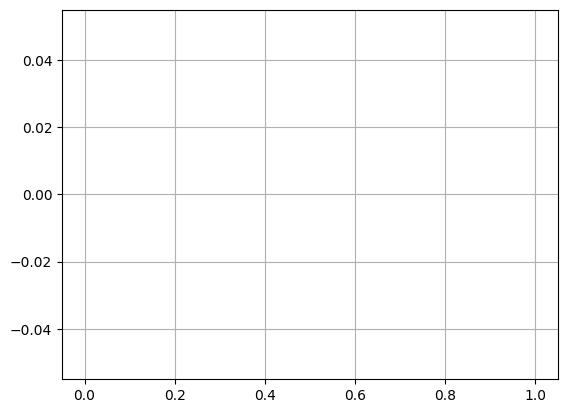

In [10]:


if MODEL_TYPE=='protenix' and VALIDATION:
    import warnings
    warnings.filterwarnings("ignore")  
    
    train_df['protenix_tm_score']=None
    dataset = DictDataset(
        seq_list=train_df.sequence,
        dump_dir='output',
        id_list=train_df.target_id,
        msa_root_1="/kaggle/input/stanford-rna-3d-folding/MSA",
        msa_root_2="/kaggle/input/stanford-rna-3d-folding/MSA_v2",
    )
    num_data = len(dataset)
    for i, seq in tqdm(enumerate(train_df.sequence),total=num_data):
        if train_df.loc[i,'protenix_tm_score']!=None:
            continue
        if len(seq)>300:
            continue
        target_id = train_df.loc[i,'target_id']
        truth_df = get_truth_df(target_id)
        if sum(~np.isnan(truth_df.x_1))<3:
            continue
        data, atom_array, data_error_message=dataset[i]
        if data_error_message!='':
            continue
        print("📦 keys in input data:", data['input_feature_dict'].keys())
        if "msa_feat" in data['input_feature_dict']:
            msa_feat = data['input_feature_dict']['msa_feat']
            print("✅ msa_feat present, shape:", msa_feat.shape)
            print("📊 sample values:", msa_feat[0, :2, :5])
        else:
            print("❌ msa_feat not present → MSA not used")

        new_configs = update_inference_configs(configs, data["N_token"].item())
        runner.update_model_configs(new_configs)
        prediction = runner.predict(data)
        prediction=prediction['coordinate'][:,data['input_feature_dict']['atom_to_tokatom_idx']==12]       
        result = parse_output_to_df(prediction[:1], seq, target_id)[0]
        try:
            tm_score, transform = call_usalign(result, truth_df, verbose=0)
            train_df.loc[i,'protenix_tm_score']=tm_score
        except:
            pass
        if (time.time()-time0)>(12*3600-360):
            break
    train_df.to_csv('tm_scores.csv', index=False)
    print(train_df.protenix_tm_score.mean())
    display(train_df.protenix_tm_score.hist())

In [11]:
from scipy.ndimage import gaussian_filter1d

def smooth_coords(df, sigma=1.0):
    df = df.copy()
    for n in range(1, 6):  # 5개의 구조 (x_1 ~ x_5, y_1 ~ y_5, z_1 ~ z_5)
        for axis in ['x', 'y', 'z']:
            col = f"{axis}_{n}"
            if col in df.columns:
                df[col] = gaussian_filter1d(df[col].values, sigma=sigma)
    return df

In [12]:
if MODEL_TYPE=='protenix' and not VALIDATION:
    test_df=pd.read_csv('/kaggle/input/stanford-rna-3d-folding/test_sequences.csv')
    import warnings
    warnings.filterwarnings("ignore")  
    
    dataset = DictDataset(test_df.sequence, dump_dir='output', id_list=test_df.target_id, use_msa_server=True)
    num_data = len(dataset)
    for i, seq in tqdm(enumerate(test_df.sequence),total=num_data):
        try:
            data, atom_array, data_error_message=dataset[i]
            target_id = data["sample_name"]
            assert target_id==test_df.target_id[i]
            assert data_error_message==''
            
            new_configs = update_inference_configs(configs, data["N_token"].item())
            runner.update_model_configs(new_configs)
            prediction = runner.predict(data)
            prediction=prediction['coordinate'][:,data['input_feature_dict']['atom_to_tokatom_idx']==12]

            result = parse_output_to_df(prediction, seq, target_id)[0]
        except:
            target_id==test_df.target_id[i]
            print('Failed to predict', target_id)
            result=pd.DataFrame(columns=['ID', 'resname', 'resid', 
                                         'x_1', 'y_1', 'z_1', 
                                         'x_2', 'y_2', 'z_2',
                                         'x_3', 'y_3', 'z_3', 
                                         'x_4', 'y_4', 'z_4', 
                                         'x_5', 'y_5', 'z_5'], 
                                         data=[[target_id, x, j+1] + [0.0]*15 for j, x in enumerate(seq)])
        result = smooth_coords(result, sigma=1.0)
        result['ID']=result.apply(lambda x: x.ID + '_' + str(x.resid), axis=1)
        result.to_csv('submission.csv', index=False, mode='a', header=(i==0))
        torch.cuda.empty_cache()

    display(pd.read_csv('submission.csv'))